In [2]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# plt.rcParams['figure.figsize'] = [8.0, 8.0]
%config InlineBackend.figure_formats = ['retina']
plt.rcParams['figure.dpi'] = 140
plt.rcParams['savefig.dpi'] = 300

In [3]:
# plotting options - light blue & light green colors
color=['#a6cee3', '#b2df8a']

# pandas options to show full text
pd.set_option('display.max_colwidth', None)

In [4]:
# Update the default parameters for Matplotlib plots to specify various aspects of the plot's appearance,
# including the figure size, colors, gridlines, fonts, and more
plt.rcParams.update({
    # Overall Figure Aesthetics
    'figure.figsize': (8, 5),
    'figure.facecolor': 'white',

    # Axes and Grid
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.grid.which': 'major',
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,

    # Spines (Borders)
    'axes.spines.top': False,
    'axes.spines.right': False,

    # Ticks and Tick Labels
    'xtick.bottom': True,
    'xtick.major.size': 3,
    'xtick.minor.size': 0,
    'ytick.left': True,
    'ytick.major.size': 3,
    'ytick.minor.size': 0,

    # Fonts and Text
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans', 'Lucida Grande', 'Verdana'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,

    # Lines and Markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Colors
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'axes.titlecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
})

In [42]:
# Standard Library
import itertools
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statsmodels
from statsmodels.api import tsa
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [43]:
# scikit-learn
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prophet
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# XGboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree


# Utils
# from ts_utils import load_and_clean_air_traffic, \
#     lag_plots, \
#     decompose_series, \
#     perform_adf_test, \
#     perform_kpss_test   


plt.rcParams["figure.figsize"] = (9,6)

## Data Overview

In [5]:
east_cleaned_pd = pd.read_csv('../data/east_england_data_revised_cleaned.csv')

# Convert columns back to datetime
east_cleaned_pd['count_date'] = pd.to_datetime(east_cleaned_pd['count_date'], errors='coerce')
east_cleaned_pd['timestamp'] = pd.to_datetime(east_cleaned_pd['timestamp'], errors='coerce')

# Convert 'Month' and 'Day' back to int32
east_cleaned_pd['Month'] = east_cleaned_pd['Month'].astype('int32')
east_cleaned_pd['Day'] = east_cleaned_pd['Day'].astype('int32')

# Ensure other columns are properly cast
east_cleaned_pd['count_point_id'] = east_cleaned_pd['count_point_id'].astype('int64')
east_cleaned_pd['hour'] = east_cleaned_pd['hour'].astype('int64')
east_cleaned_pd['all_motor_vehicles'] = east_cleaned_pd['all_motor_vehicles'].astype('float')

In [6]:
east_cleaned_pd.head()

count_point_id direction_of_travel count_date  hour local_authority_name  \
0            6003                   N 2004-05-21     7         Bedfordshire   
1            6003                   N 2004-05-21     8         Bedfordshire   
2            6003                   N 2004-05-21     9         Bedfordshire   
3            6003                   N 2004-05-21    10         Bedfordshire   
4            6003                   N 2004-05-21    11         Bedfordshire   

  road_type  all_motor_vehicles  Month Day_of_Week  Day           timestamp  
0     Major              4006.0      5      Friday   21 2004-05-21 07:00:00  
1     Major              4142.0      5      Friday   21 2004-05-21 08:00:00  
2     Major              3325.0      5      Friday   21 2004-05-21 09:00:00  
3     Major              3500.0      5      Friday   21 2004-05-21 10:00:00  
4     Major              3693.0      5      Friday   21 2004-05-21 11:00:00

In [7]:
east_cleaned_pd.shape

(549471, 11)

In [8]:
# Verify the data types are correct
print(east_cleaned_pd.dtypes)

count_point_id                   int64
direction_of_travel             object
count_date              datetime64[ns]
hour                             int64
local_authority_name            object
road_type                       object
all_motor_vehicles             float64
Month                            int32
Day_of_Week                     object
Day                              int32
timestamp               datetime64[ns]
dtype: object


In [9]:
east_cleaned_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549471 entries, 0 to 549470
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   count_point_id        549471 non-null  int64         
 1   direction_of_travel   549471 non-null  object        
 2   count_date            549471 non-null  datetime64[ns]
 3   hour                  549471 non-null  int64         
 4   local_authority_name  549471 non-null  object        
 5   road_type             549471 non-null  object        
 6   all_motor_vehicles    549469 non-null  float64       
 7   Month                 549471 non-null  int32         
 8   Day_of_Week           549471 non-null  object        
 9   Day                   549471 non-null  int32         
 10  timestamp             549471 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(2), int64(2), object(4)
memory usage: 41.9+ MB


In [10]:
east_cleaned_pd.describe()

count_point_id                     count_date           hour  \
count   549471.000000                         549471  549471.000000   
mean    565831.030231  2009-11-07 18:59:26.527078144      12.500285   
min       6003.000000            2000-03-17 00:00:00       3.000000   
25%      48454.000000            2003-10-09 00:00:00      10.000000   
50%     808764.000000            2008-09-09 00:00:00      13.000000   
75%     941675.000000            2015-05-22 00:00:00      16.000000   
max     999996.000000            2023-11-07 00:00:00      18.000000   
std     430273.273934                            NaN       3.452088   

       all_motor_vehicles          Month            Day  \
count       549469.000000  549471.000000  549471.000000   
mean           526.039518       6.511996      15.845985   
min              0.000000       3.000000       1.000000   
25%             45.000000       5.000000       9.000000   
50%            201.000000       6.000000      16.000000   
75%            649.000000       9.000000      23.000000   
max           8664.000000      11.000000      31.000000   
std            806.097154       2.273773       8.451963   

                           timestamp  
count                         549471  
mean   2009-11-08 07:29:27.552428032  
min              2000-03-17 07:00:00  
25%              2003-10-09 15:00:00  
50%              2008-09-09 08:00:00  
75%              2015-05-22 07:30:00  
max              2023-11-07 18:00:00  
std                              NaN

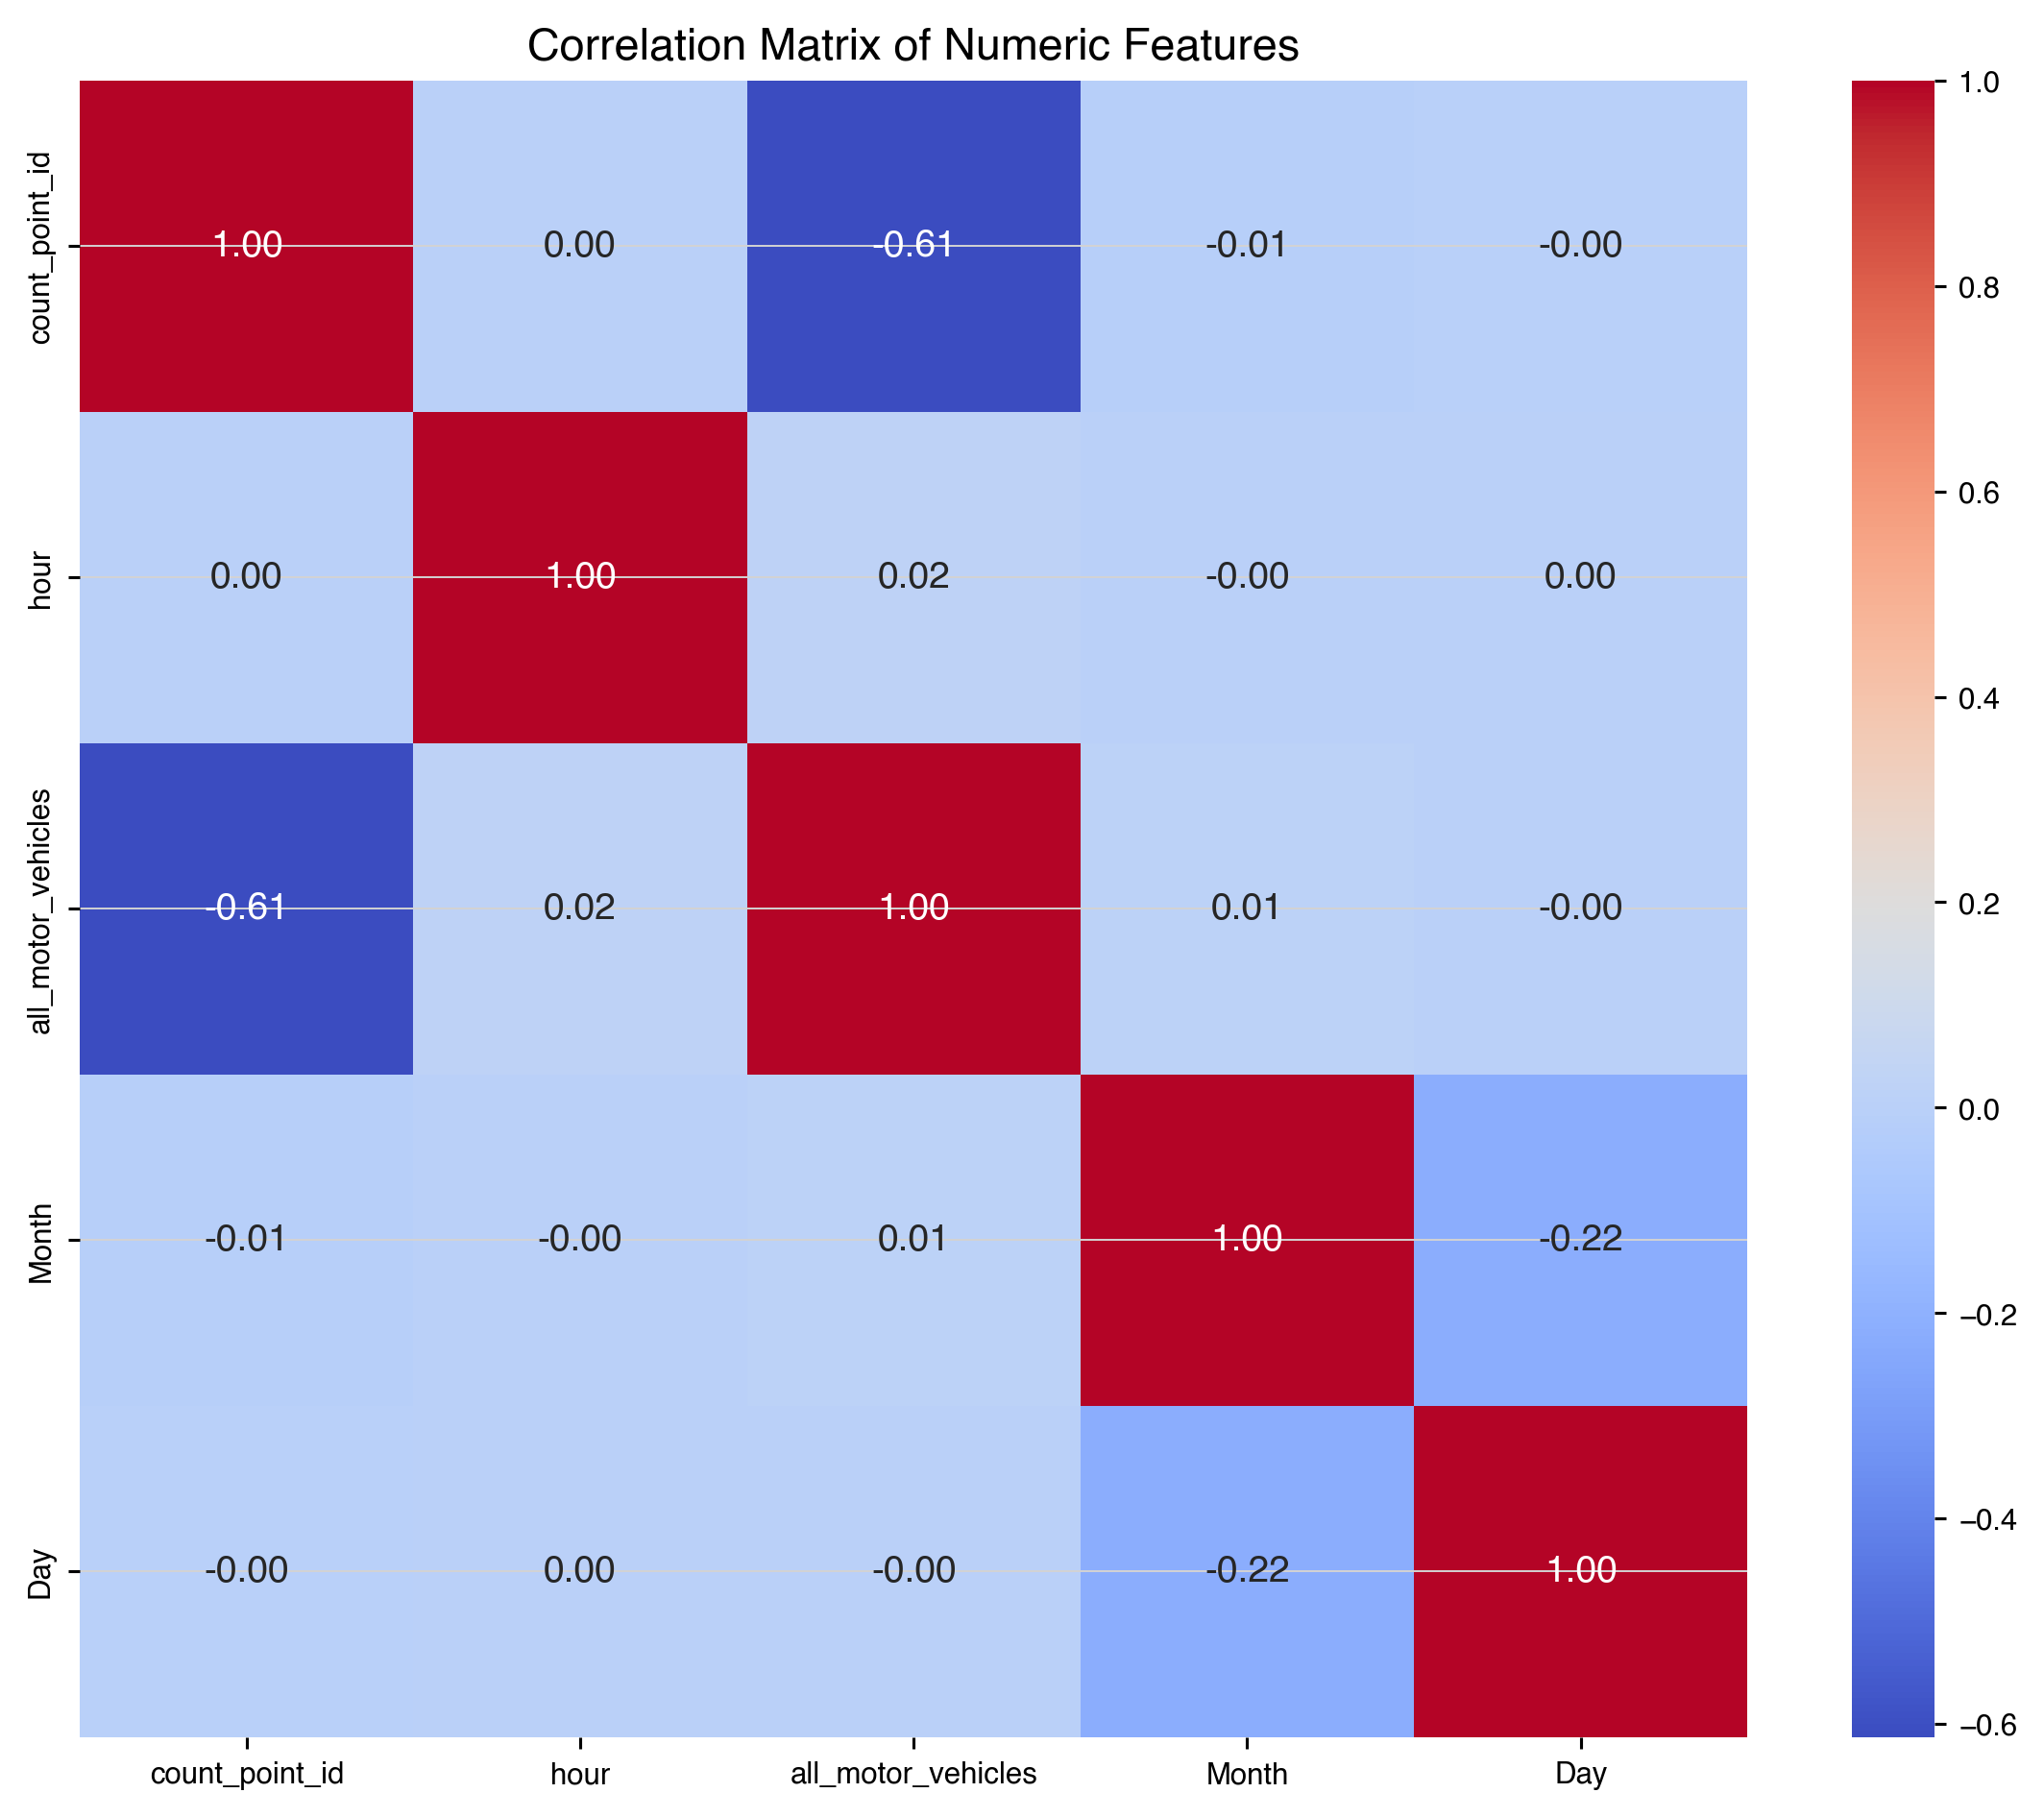

In [60]:
# Select only numeric columns
numeric_columns = east_cleaned_pd.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = numeric_columns.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

# Set the title
plt.title('Correlation Matrix of Numeric Features')

# Show the plot
plt.show()

In [11]:
east_cleaned_pd.isnull().sum()

count_point_id          0
direction_of_travel     0
count_date              0
hour                    0
local_authority_name    0
road_type               0
all_motor_vehicles      2
Month                   0
Day_of_Week             0
Day                     0
timestamp               0
dtype: int64

In [12]:
east_cleaned_pd = east_cleaned_pd.dropna()

In [13]:
east_cleaned_pd.isnull().sum()

count_point_id          0
direction_of_travel     0
count_date              0
hour                    0
local_authority_name    0
road_type               0
all_motor_vehicles      0
Month                   0
Day_of_Week             0
Day                     0
timestamp               0
dtype: int64

In [14]:
east_cleaned_pd.duplicated().sum()

0

In [15]:
print(f" The shape of the cleaned data is {east_cleaned_pd.shape}")

 The shape of the cleaned data is (549469, 11)


In [61]:
east_cleaned_pd.columns

Index(['count_point_id', 'direction_of_travel', 'count_date', 'hour',
       'local_authority_name', 'road_type', 'all_motor_vehicles', 'Month',
       'Day_of_Week', 'Day', 'timestamp'],
      dtype='object')

# Exploratory Data Analysis

In [16]:
def format_number(num, p):
 
    return f"{num / 1_000_000:.1f} m".rstrip('0').rstrip('.')

### Traffic Density Analysis

In [17]:
east_cleaned_pd.columns

Index(['count_point_id', 'direction_of_travel', 'count_date', 'hour',
       'local_authority_name', 'road_type', 'all_motor_vehicles', 'Month',
       'Day_of_Week', 'Day', 'timestamp'],
      dtype='object')

In [18]:
locality = east_cleaned_pd['local_authority_name'].value_counts()
locality

local_authority_name
Essex                   134301
Hertfordshire           104678
Norfolk                  94647
Cambridgeshire           62014
Suffolk                  61463
Peterborough             22410
Thurrock                 16216
Bedfordshire             14842
Central Bedfordshire     12251
Luton                     9807
Southend-on-Sea           8669
Bedford                   8171
Name: count, dtype: int64

In [19]:
vehicle_per_locality = east_cleaned_pd[['local_authority_name','all_motor_vehicles']].value_counts()
vehicle_per_locality.head(10)

local_authority_name  all_motor_vehicles
Norfolk               5.0                   1139
                      4.0                   1123
                      6.0                   1097
                      3.0                   1085
                      8.0                   1080
Essex                 12.0                  1059
                      14.0                  1056
                      10.0                  1049
Norfolk               7.0                   1039
Essex                 13.0                  1030
Name: count, dtype: int64

In [20]:
# Group by road_category and sum the total traffic
traffic_by_road_type = east_cleaned_pd.groupby('road_type')['all_motor_vehicles'].sum().reset_index()
traffic_by_road_type.head()

road_type  all_motor_vehicles
0     Major         250114877.0
1     Minor          38927531.0

/var/folders/_z/nz5spzqj2rl11n5lc_k1cwwc0000gn/T/ipykernel_11110/1686956056.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='road_type', y='all_motor_vehicles', data=traffic_by_road_type, palette='coolwarm')


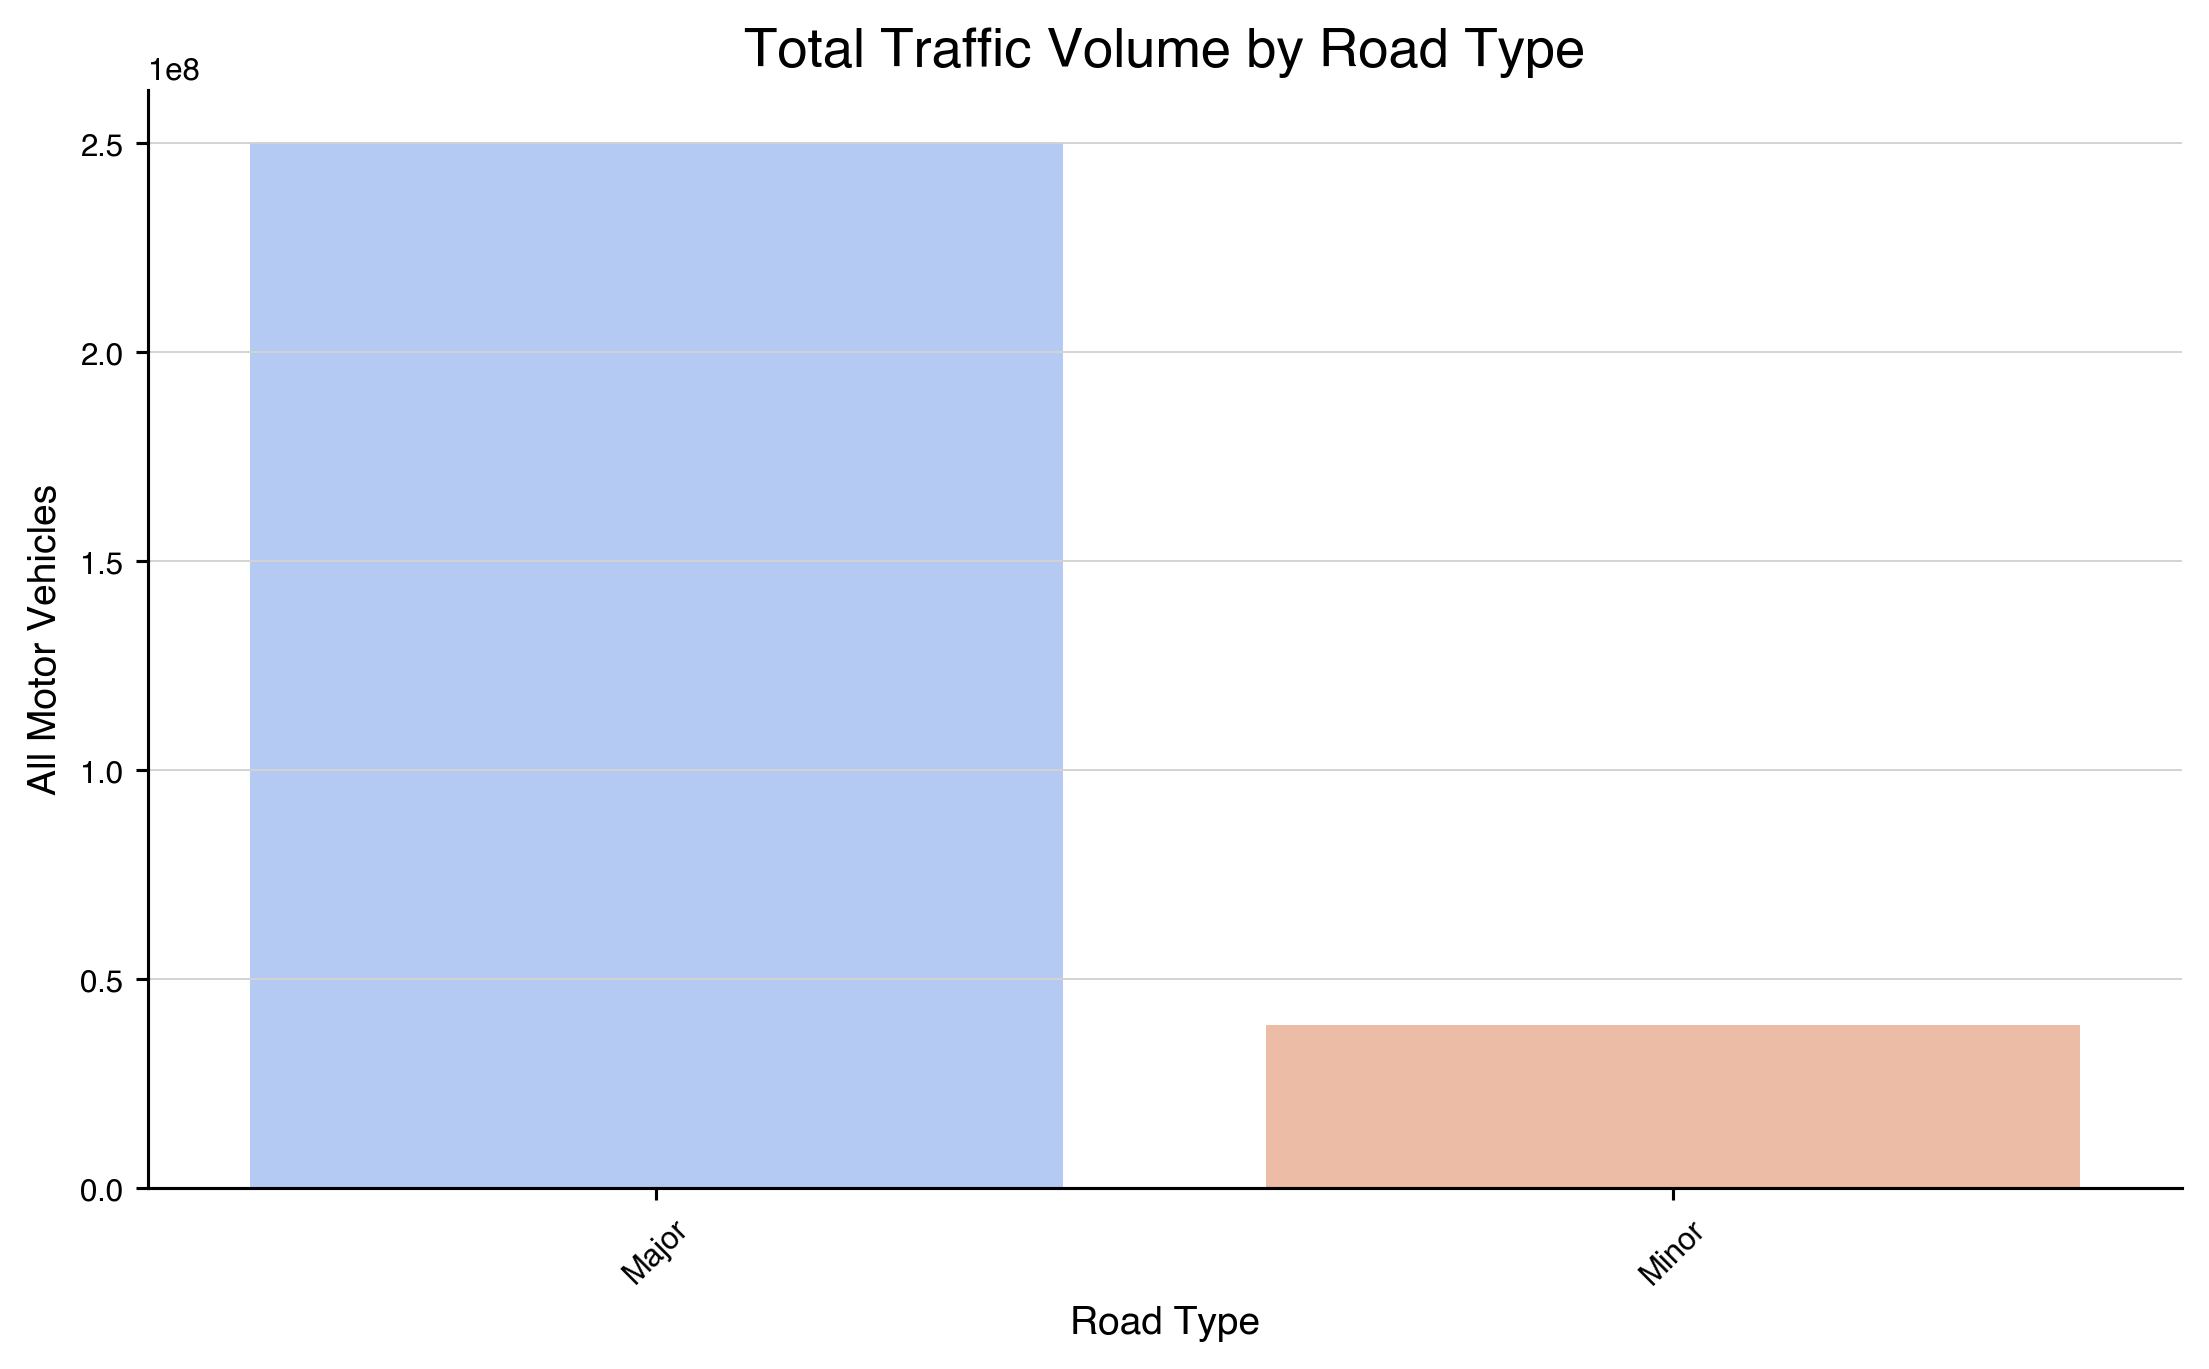

In [21]:
plt.figure()
sns.barplot(x='road_type', y='all_motor_vehicles', data=traffic_by_road_type, palette='coolwarm')
plt.title('Total Traffic Volume by Road Type', fontsize=14)
plt.xlabel('Road Type')
plt.ylabel('All Motor Vehicles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Direction of travel

In [22]:
east_cleaned_pd['direction_of_travel'].value_counts()

direction_of_travel
N    145462
S    145156
E    129541
W    129226
s        48
w        24
C        12
Name: count, dtype: int64

In [23]:
traffic_direction = east_cleaned_pd.groupby('direction_of_travel')['all_motor_vehicles'].sum()
traffic_direction.head()

direction_of_travel
C         171.0
E    72090562.0
N    74203866.0
S    72172798.0
W    70514286.0
Name: all_motor_vehicles, dtype: float64

/var/folders/_z/nz5spzqj2rl11n5lc_k1cwwc0000gn/T/ipykernel_11110/2014093932.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=traffic_direction.index, y=traffic_direction.values, palette='coolwarm')


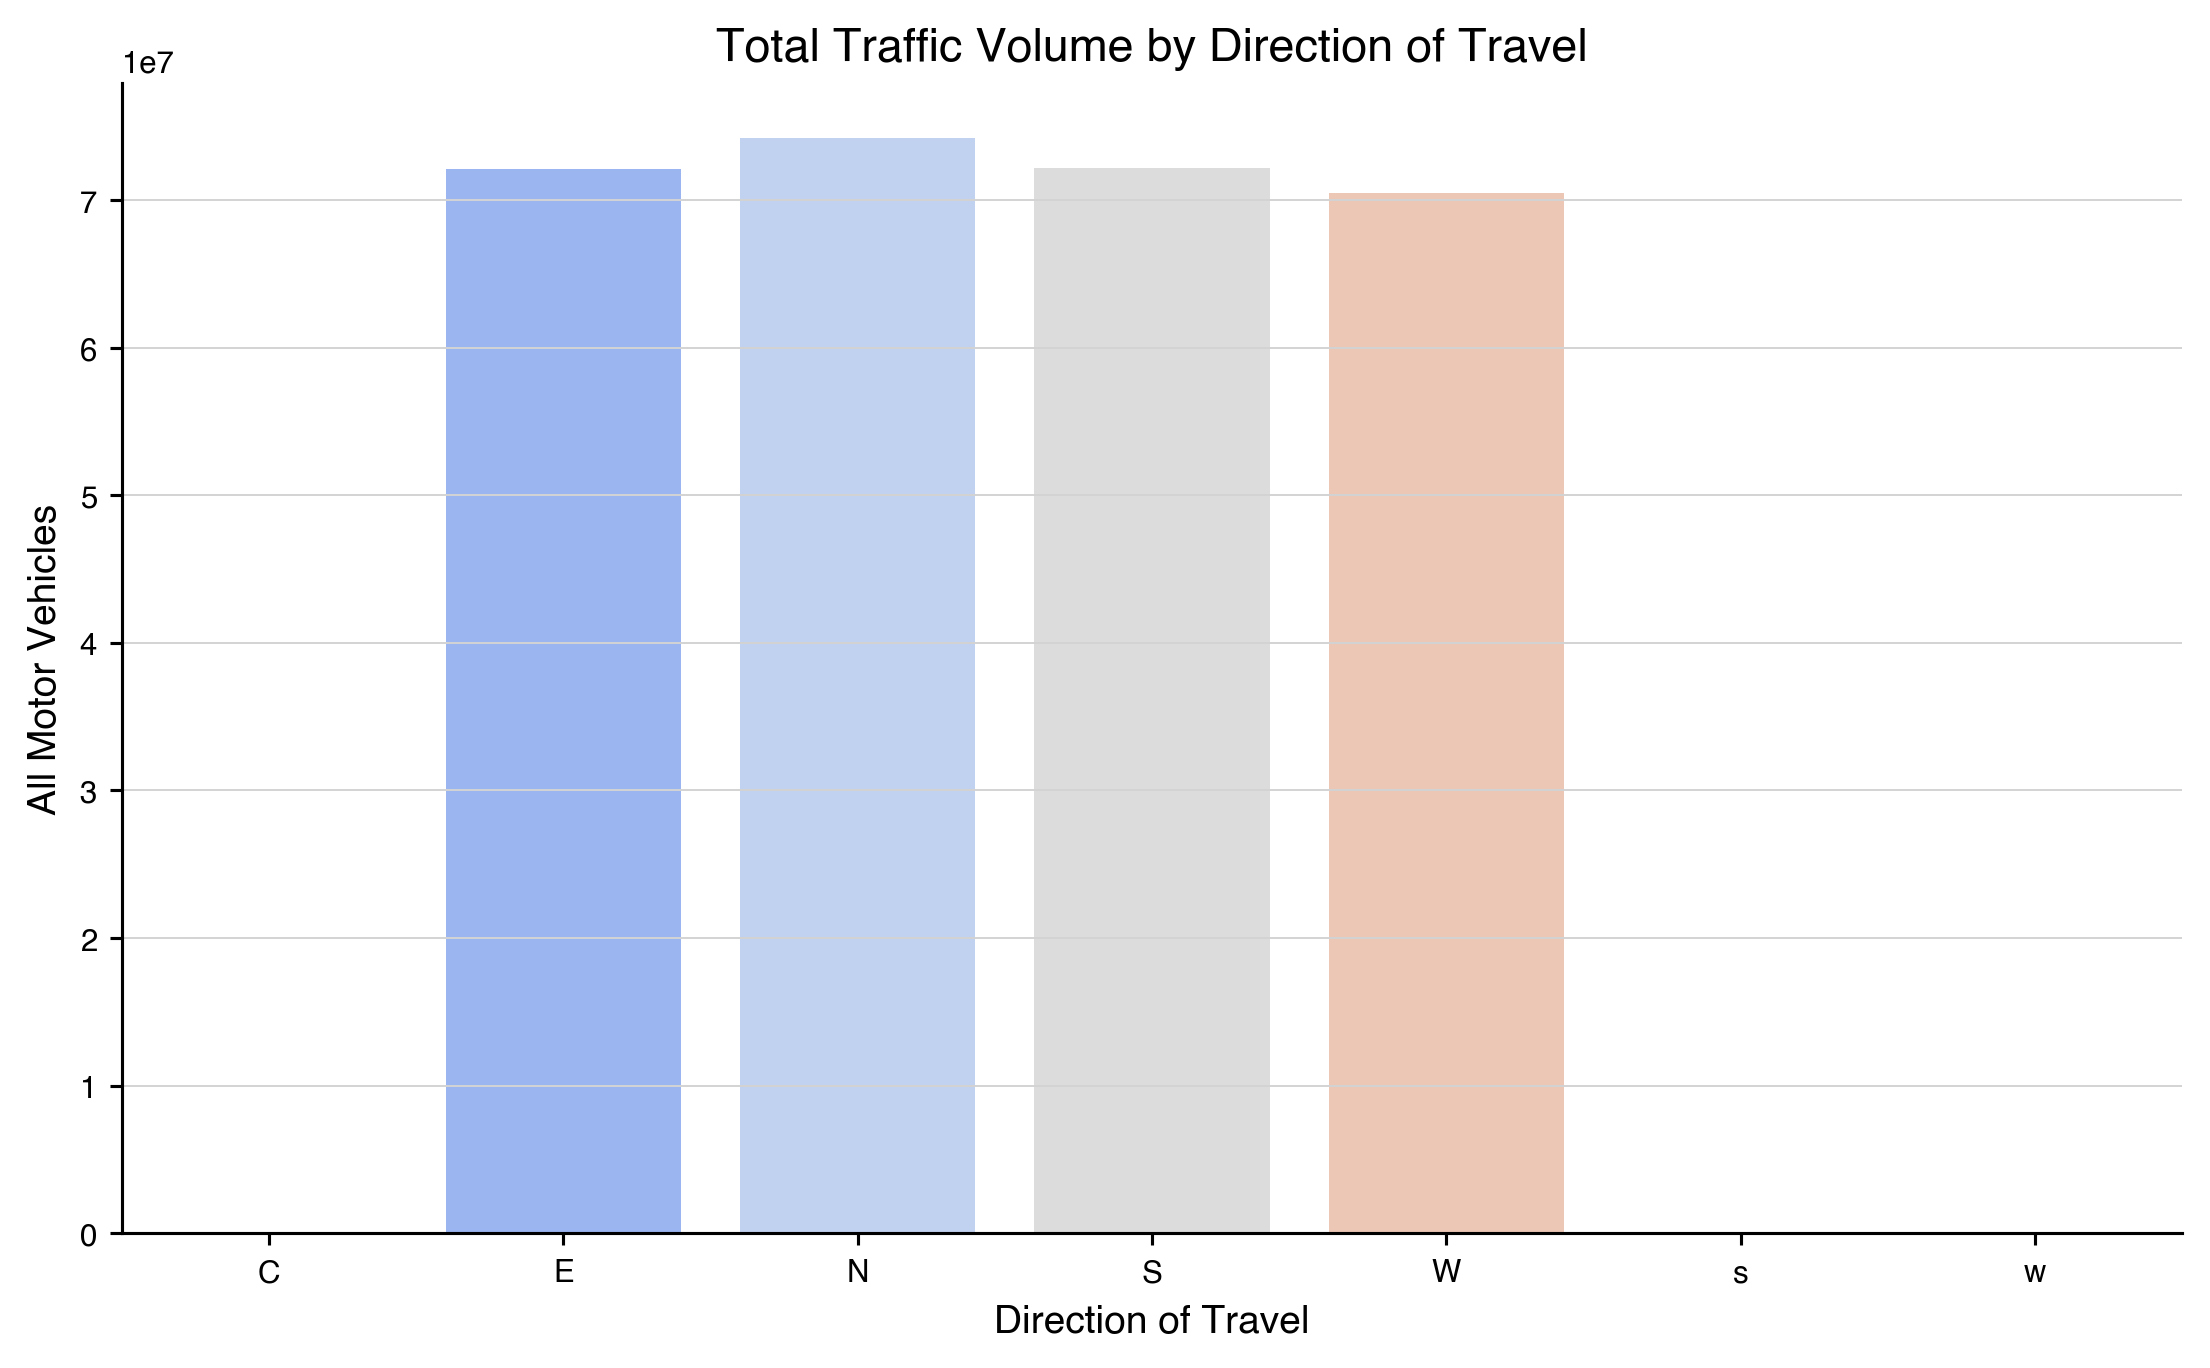

In [24]:

plt.figure()
sns.barplot(x=traffic_direction.index, y=traffic_direction.values, palette='coolwarm')
plt.title('Total Traffic Volume by Direction of Travel')
plt.xlabel('Direction of Travel')
plt.ylabel('All Motor Vehicles')
plt.tight_layout()
plt.show()


### Aggregated Data

In [26]:
print(east_cleaned_pd[['timestamp', 'count_date', 'hour']].head())

            timestamp count_date  hour
0 2004-05-21 07:00:00 2004-05-21     7
1 2004-05-21 08:00:00 2004-05-21     8
2 2004-05-21 09:00:00 2004-05-21     9
3 2004-05-21 10:00:00 2004-05-21    10
4 2004-05-21 11:00:00 2004-05-21    11


In [27]:
# group the new 'timestamp' 
hourly_grouped_data = east_cleaned_pd.groupby('timestamp').agg({"all_motor_vehicles": sum})
hourly_grouped_data.head()

all_motor_vehicles
timestamp                              
2000-03-17 07:00:00             14121.0
2000-03-17 08:00:00             15647.0
2000-03-17 09:00:00             12238.0
2000-03-17 10:00:00             11193.0
2000-03-17 11:00:00             11374.0

In [28]:
daily_grouped_data = hourly_grouped_data.resample('D').sum().sort_index(ascending=False)
daily_grouped_data.head(10)

all_motor_vehicles
timestamp                     
2023-11-07              2721.0
2023-11-06             12403.0
2023-11-05                 0.0
2023-11-04                 0.0
2023-11-03              2290.0
2023-11-02                 0.0
2023-11-01             12395.0
2023-10-31                 0.0
2023-10-30                 0.0
2023-10-29                 0.0

In [29]:
monthly_data = hourly_grouped_data.resample('MS').sum()
monthly_data

all_motor_vehicles
timestamp                     
2000-03-01           1630674.0
2000-04-01           1816143.0
2000-05-01           3735104.0
2000-06-01           3469829.0
2000-07-01           1868494.0
...                        ...
2023-07-01            896011.0
2023-08-01                 0.0
2023-09-01            796538.0
2023-10-01            611725.0
2023-11-01             29809.0

[285 rows x 1 columns]

In [65]:
hourly_average_traffic = hourly_grouped_data.groupby(['timestamp']).aggregate({'all_motor_vehicles': 'mean'})

In [67]:
hourly_average_traffic

all_motor_vehicles
timestamp                              
2000-03-17 07:00:00             14121.0
2000-03-17 08:00:00             15647.0
2000-03-17 09:00:00             12238.0
2000-03-17 10:00:00             11193.0
2000-03-17 11:00:00             11374.0
...                                 ...
2023-11-07 14:00:00               201.0
2023-11-07 15:00:00               272.0
2023-11-07 16:00:00               230.0
2023-11-07 17:00:00               310.0
2023-11-07 18:00:00               222.0

[29819 rows x 1 columns]

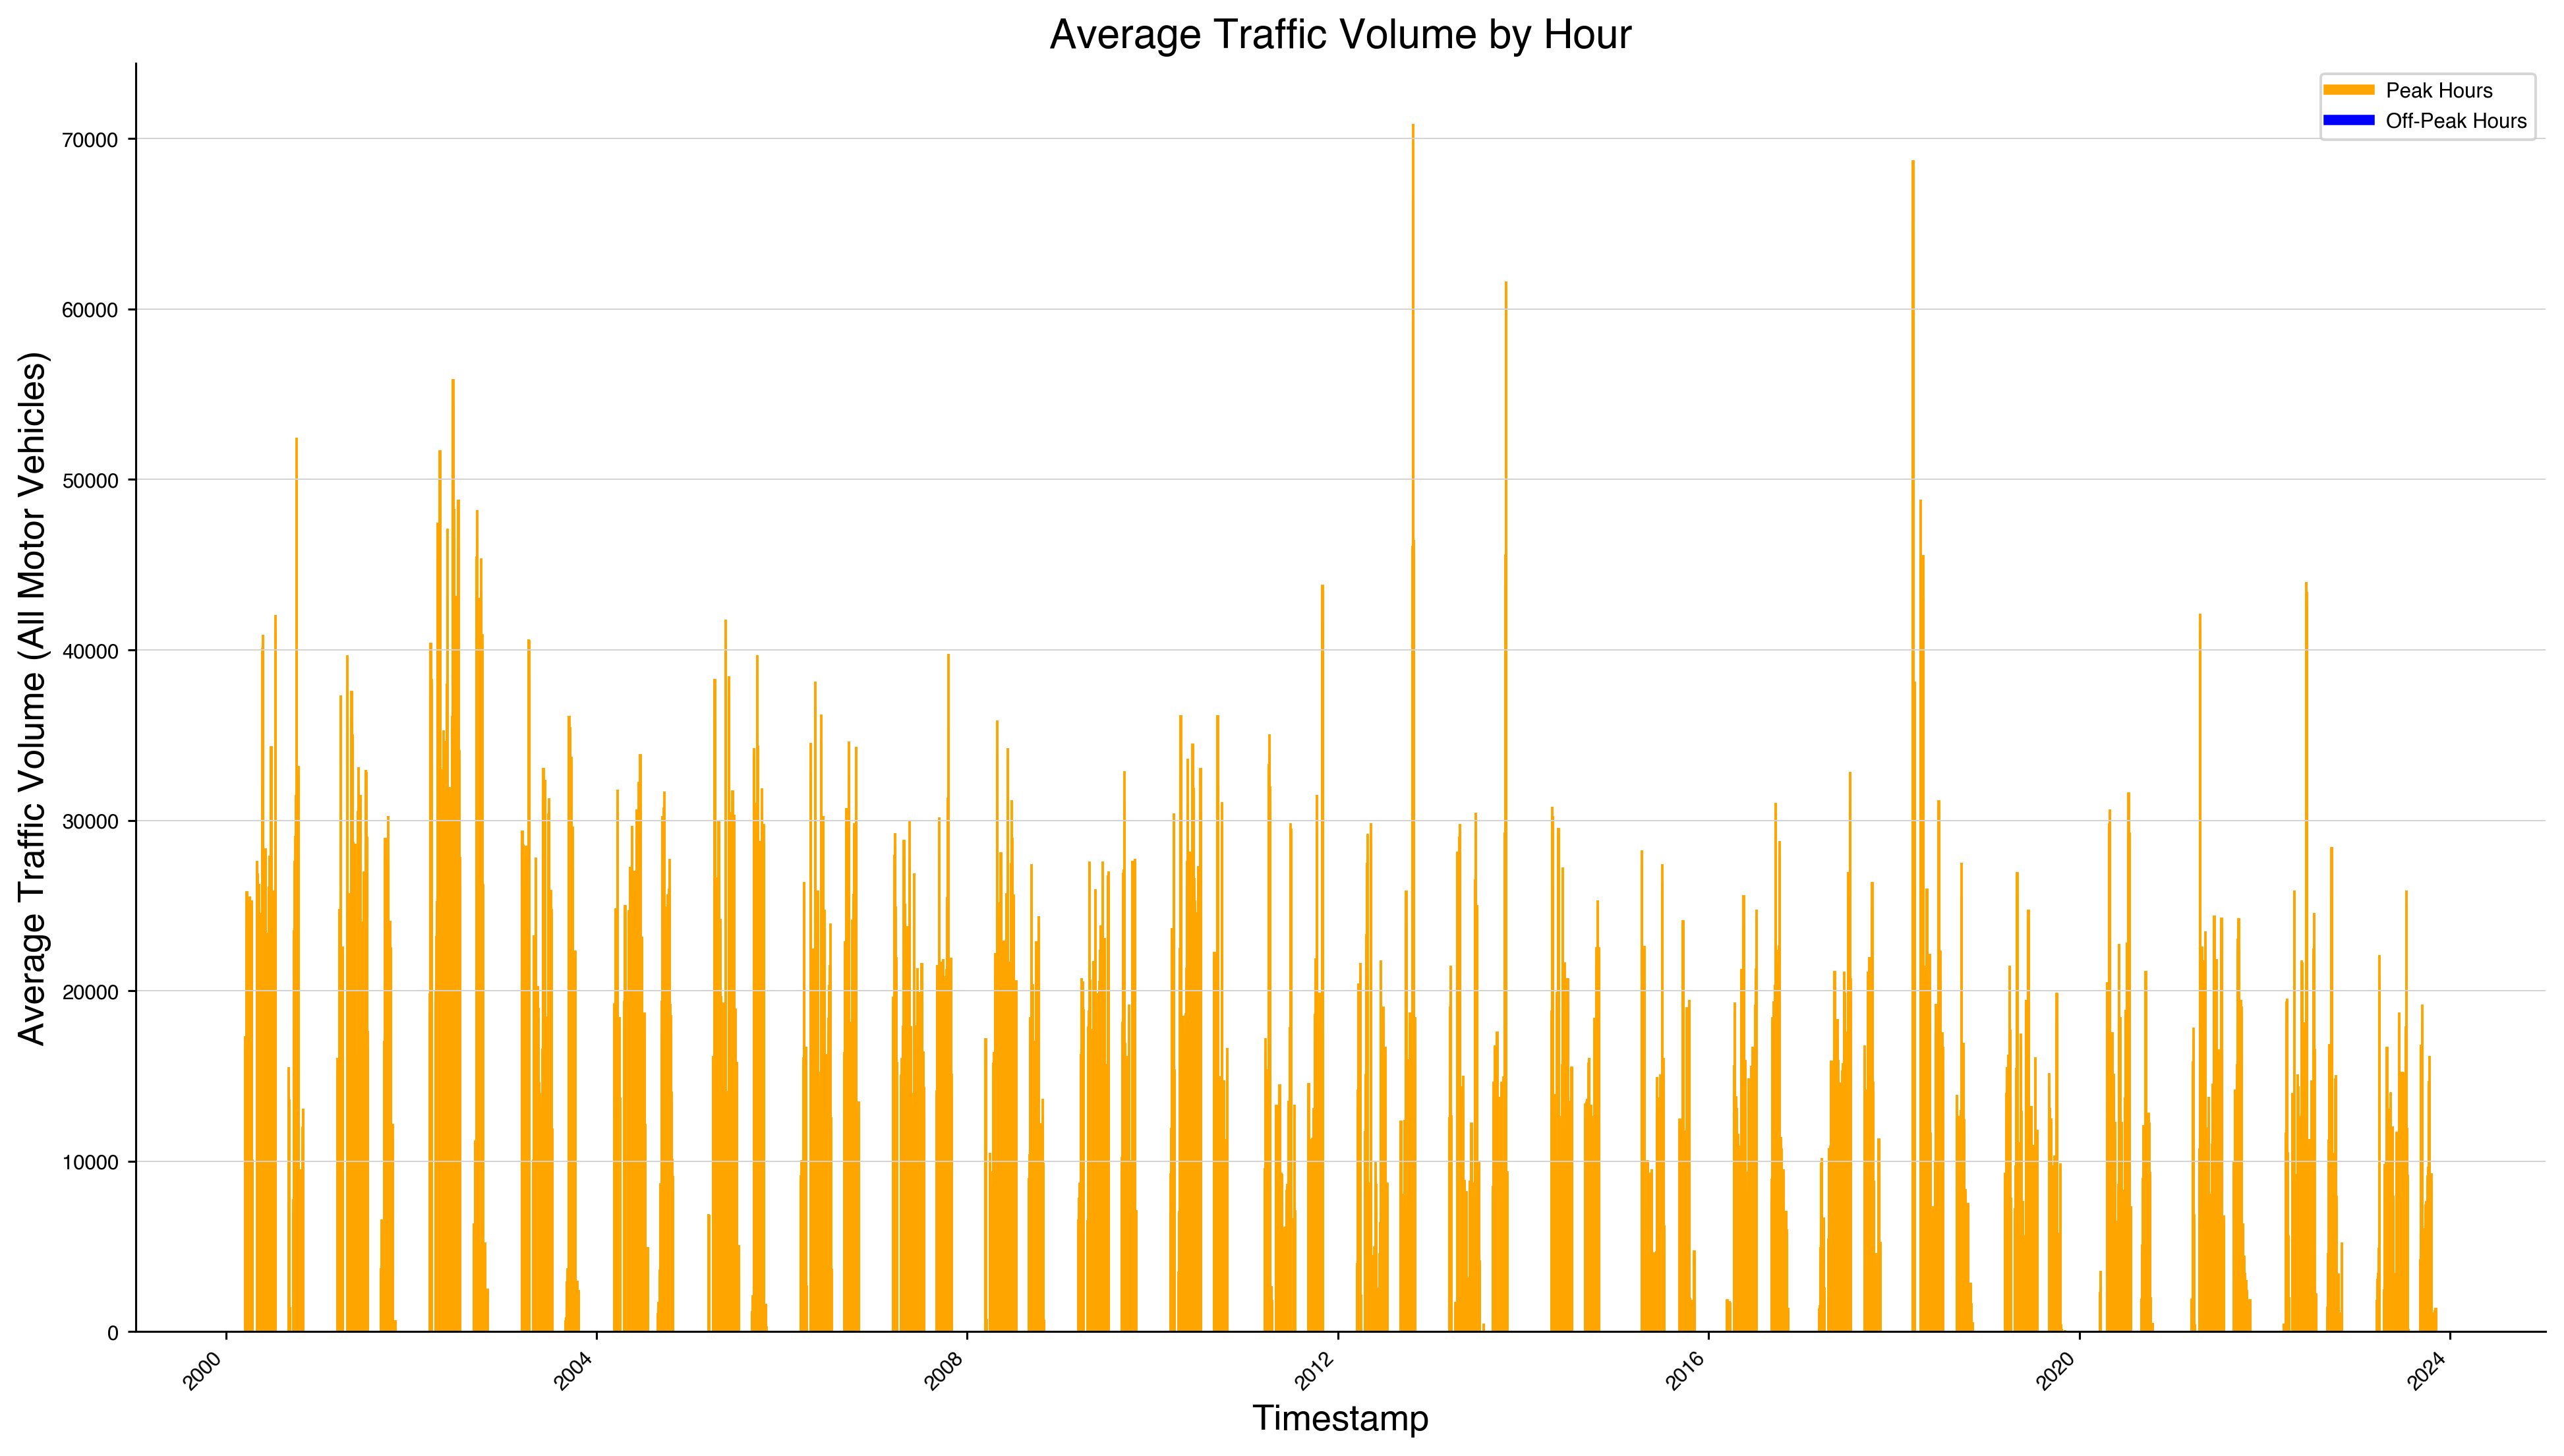

In [69]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'hourly_average_traffic' is a pandas DataFrame with 'timestamp' as the index and 'all_motor_vehicles' as the column

fig, ax = plt.subplots(figsize=(14, 8))

# Generate the bar plot for the hourly average traffic data
bars = ax.bar(hourly_average_traffic.index, hourly_average_traffic['all_motor_vehicles'], color='blue')

# Define the peak hours you want to highlight (in 24-hour format)
peak_hours = ["07", "08", "09", "15", "16", "17", "18"]

# Loop through the bars and highlight the ones that fall within peak hours
for bar, timestamp in zip(bars, hourly_average_traffic.index):
    hour = timestamp.strftime("%H")  # Extract the hour in 24-hour format
    if hour in peak_hours:
        bar.set_color('orange')

# Create custom labels for the legend
custom_lines = [plt.Line2D([0], [0], color='orange', lw=4),
                plt.Line2D([0], [0], color='blue', lw=4)]

# Add the legend to the plot
ax.legend(custom_lines, ['Peak Hours', 'Off-Peak Hours'])

# Labeling the axes and the plot title
ax.set_ylabel('Average Traffic Volume (All Motor Vehicles)', fontsize=14)
ax.set_xlabel('Timestamp', fontsize=14)
ax.set_title('Average Traffic Volume by Hour', fontsize=16)

# Rotate x-axis labels for better readability (optional, for dense data points)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()


<Axes: xlabel='timestamp'>

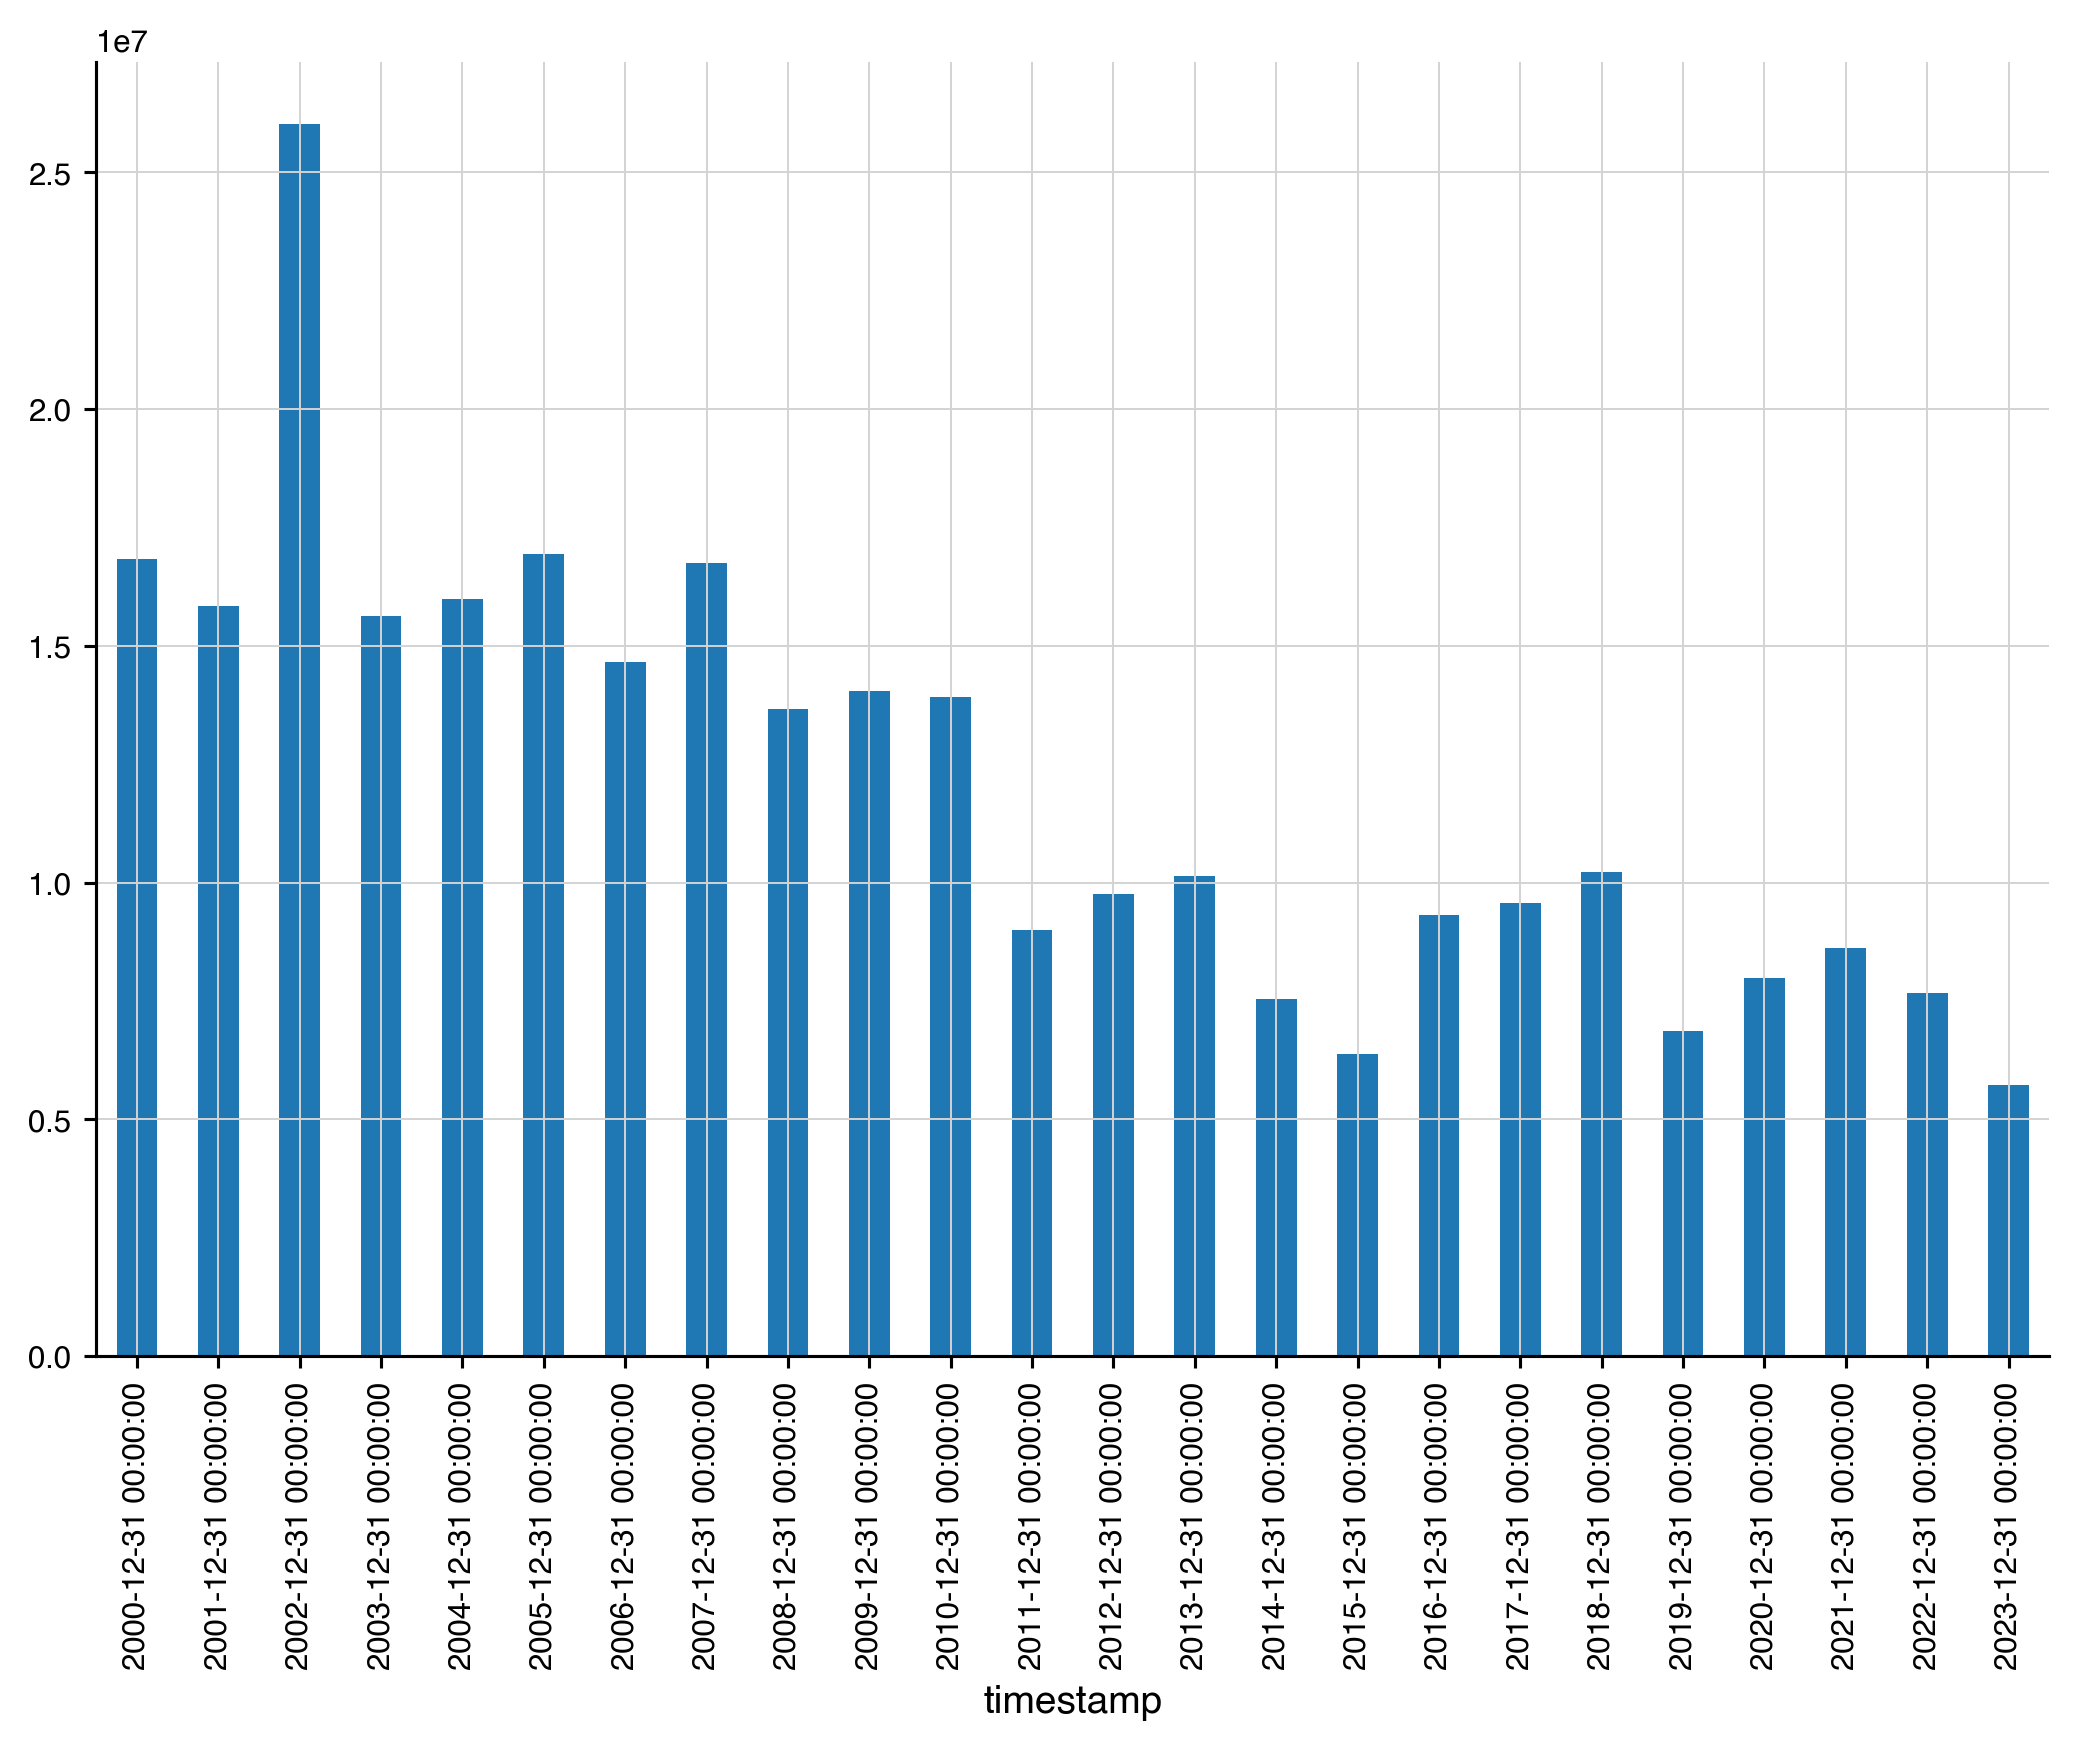

In [70]:
daily_grouped_data.resample('y').sum()['all_motor_vehicles'].plot(kind='bar')

In [71]:
monthly_data.isna().sum()

all_motor_vehicles    0
dtype: int64

In [72]:
monthly_data_zeros = monthly_data.loc[monthly_data["all_motor_vehicles"] == 0]
monthly_data_zeros.sample(10)

all_motor_vehicles
timestamp                     
2017-02-01                 0.0
2021-12-01                 0.0
2006-12-01                 0.0
2007-11-01                 0.0
2010-12-01                 0.0
2019-08-01                 0.0
2002-08-01                 0.0
2016-12-01                 0.0
2014-03-01                 0.0
2000-11-01                 0.0

In [73]:
monthly_data_zeros.resample('y').count() # finding out the monthly missing value in each year

all_motor_vehicles
timestamp                     
2000-12-31                   3
2001-12-31                   5
2002-12-31                   5
2003-12-31                   5
2004-12-31                   4
2005-12-31                   5
2006-12-31                   5
2007-12-31                   5
2008-12-31                   5
2009-12-31                   5
2010-12-31                   5
2011-12-31                   4
2012-12-31                   5
2013-12-31                   5
2014-12-31                   6
2015-12-31                   5
2016-12-31                   4
2017-12-31                   4
2018-12-31                   4
2019-12-31                   4
2020-12-31                   5
2021-12-31                   4
2022-12-31                   4
2023-12-31                   3

### Traffic Trends Analysis

**Notes**
- The main objective of this Exploratory Data Analysis (EDA) for traffic trends is to gain a deeper understanding of the key characteristics and patterns within the traffic data. The goal is to identify any recurring patterns, trends, or seasonality in traffic.

In [74]:
def plot_rolling_mean_and_std(series: pd.Series, window: int) -> None:
    """
    This function plots the rolling mean and rolling standard deviation
    of a time series to help visually inspect stationarity.
    
    Args:
        series (pd.Series): Time series data (single column)
        window (int): Window size for rolling calculations (in time units)
        
    Returns: 
        None
    """
    # Get Rolling Mean and STD
    roll_mean = series.rolling(window=window).mean()
    roll_std = series.rolling(window=window).std()

    # Plot original series, rolling mean, and rolling standard deviation
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original', color='blue', alpha=0.5)
    plt.plot(roll_mean, label=f'Rolling Mean (window={window})', color='red')
    plt.plot(roll_std, label=f'Rolling STD (window={window})', color='green')
    
    # Adding titles and labels
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

**- Using the Rolling Mean & Standard Deviation to analyze time series data using rolling statistics to assess mean and standard deviation stability over time.**

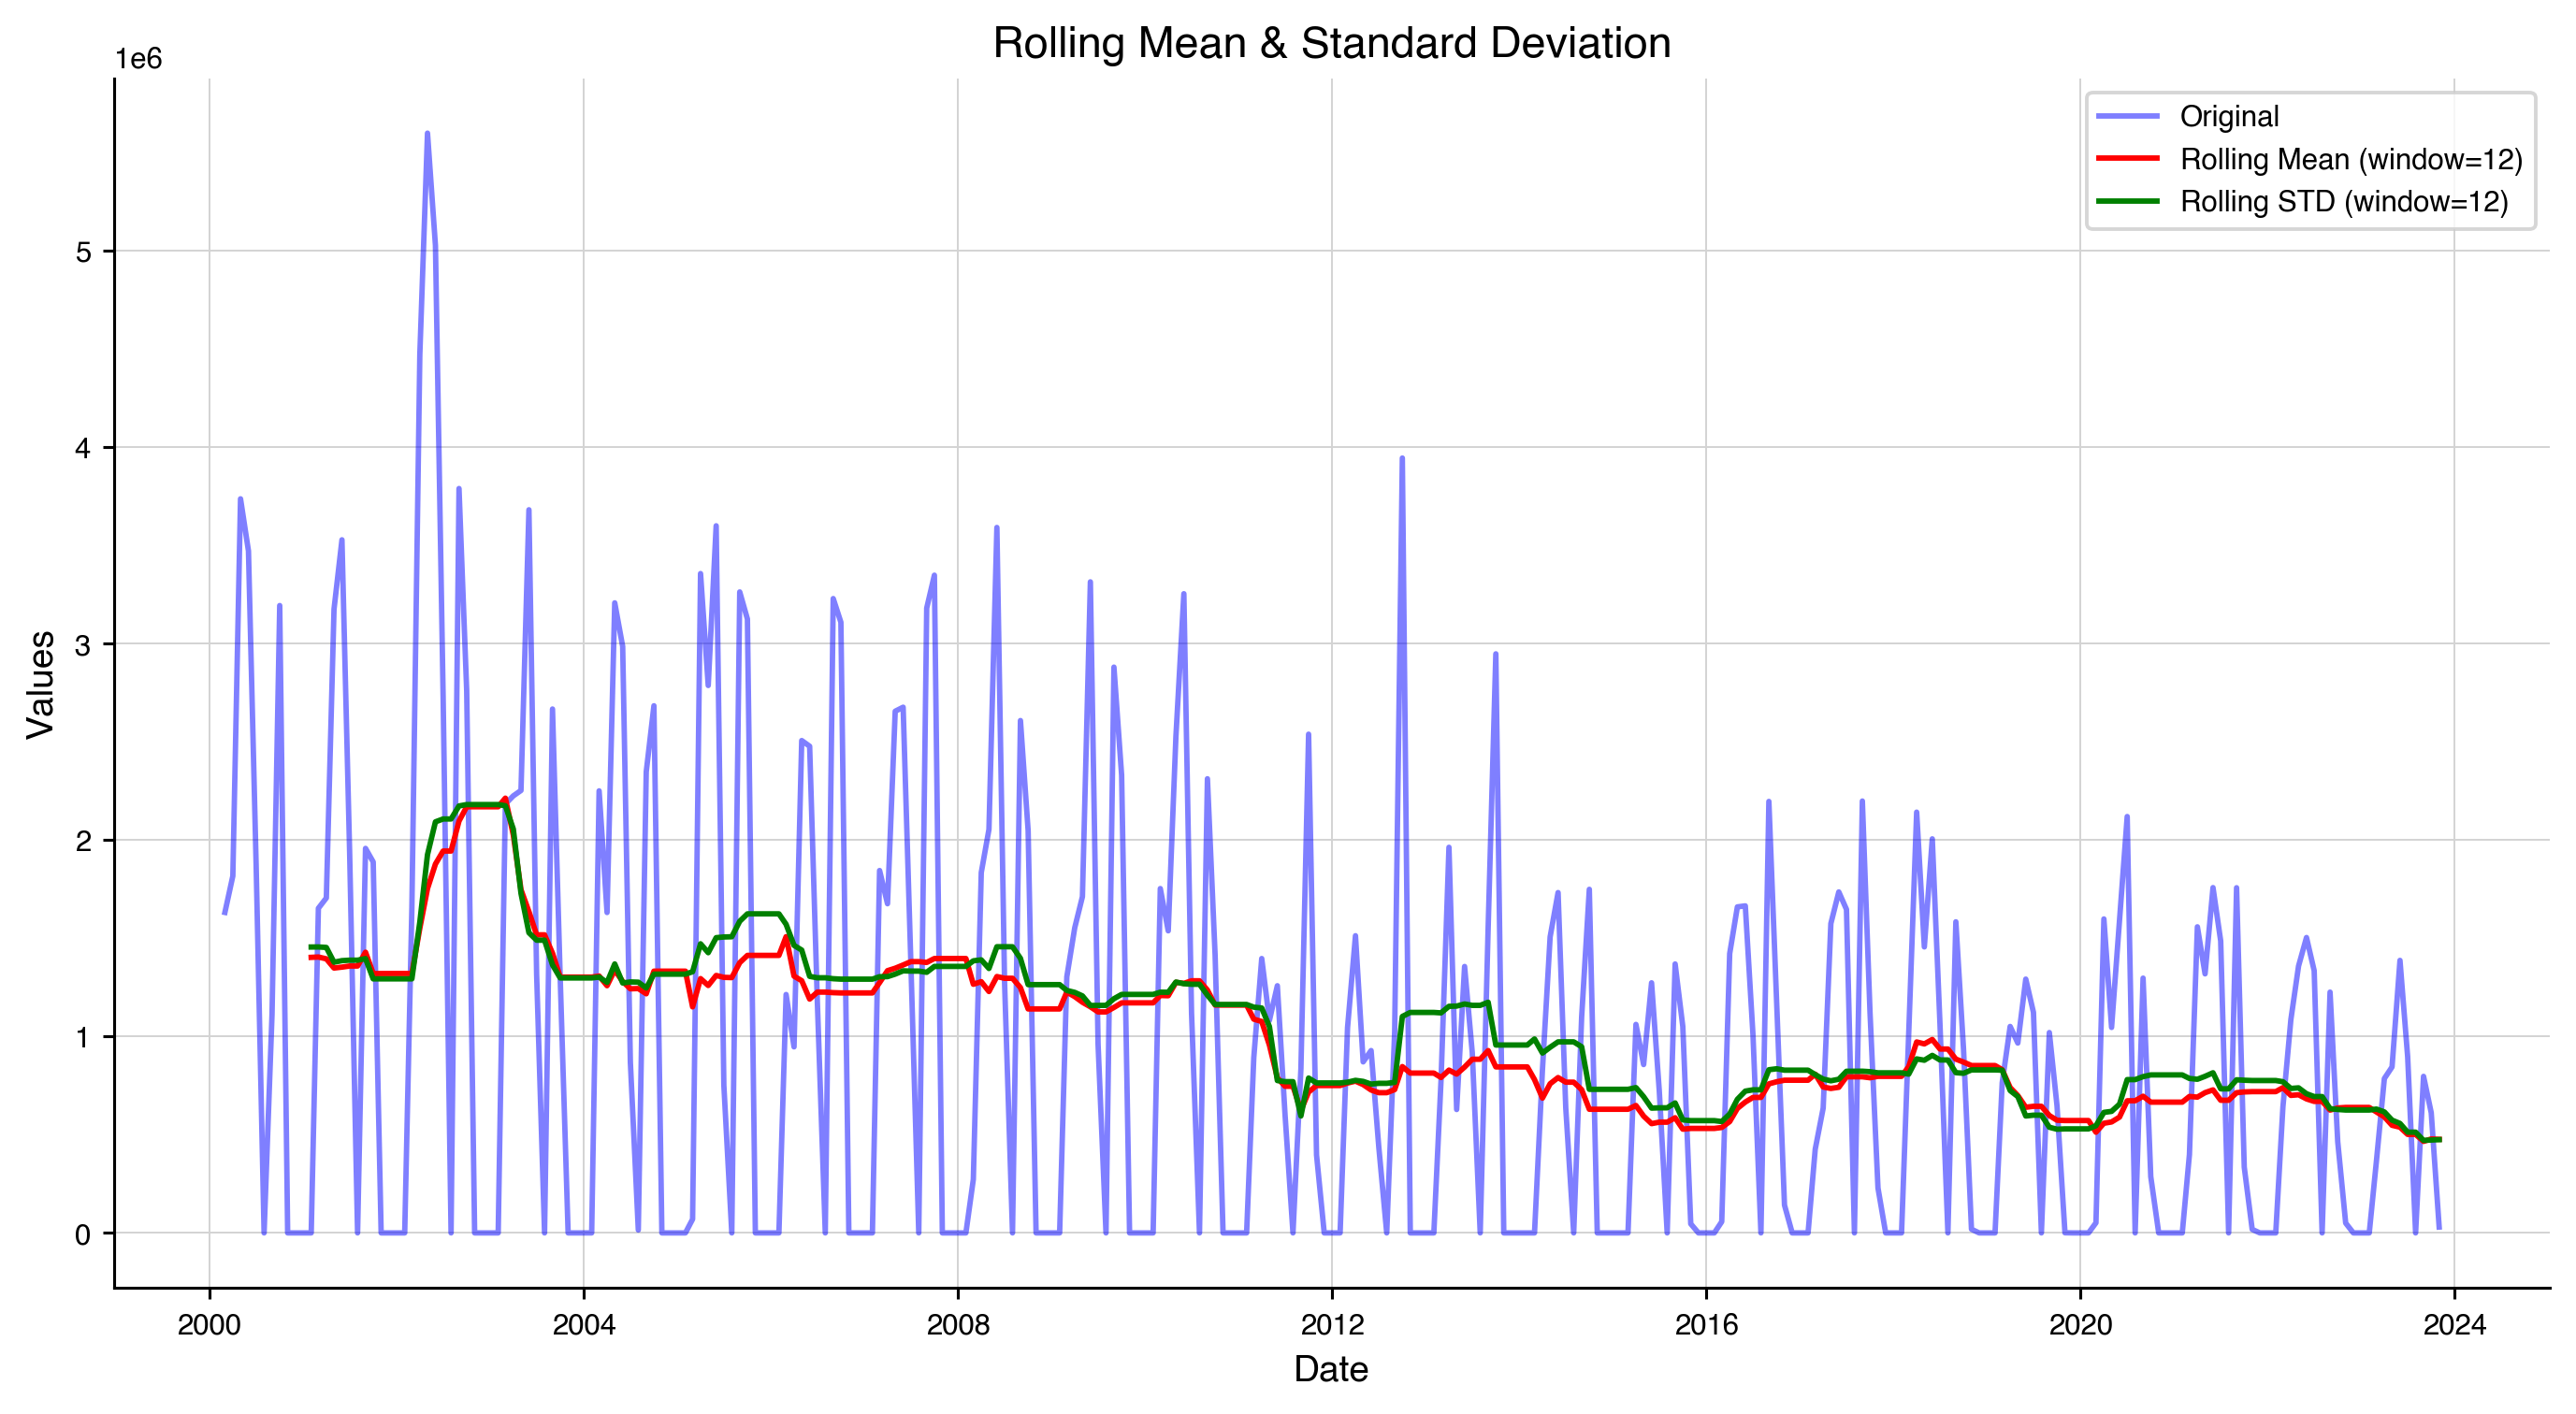

In [75]:

# Plot the rolling mean and standard deviation for a 12-month window 
plot_rolling_mean_and_std(monthly_data['all_motor_vehicles'], window=12) 

**Observations**
- **Trend Stability**: The rolling mean suggests that the underlying trend of the time series becomes relatively stable, especially from 2010 onwards.
- **Volatility**(fluctuation): There are periods of high volatility (as seen from the green line), but overall, the rolling standard deviation shows controlled volatility over time, with notable spikes during periods of significant fluctuation.
- **Seasonality**: The repeated spikes and declines in the original series may indicate some form of seasonality or cyclical behaviour, but further analysis is needed to confirm.

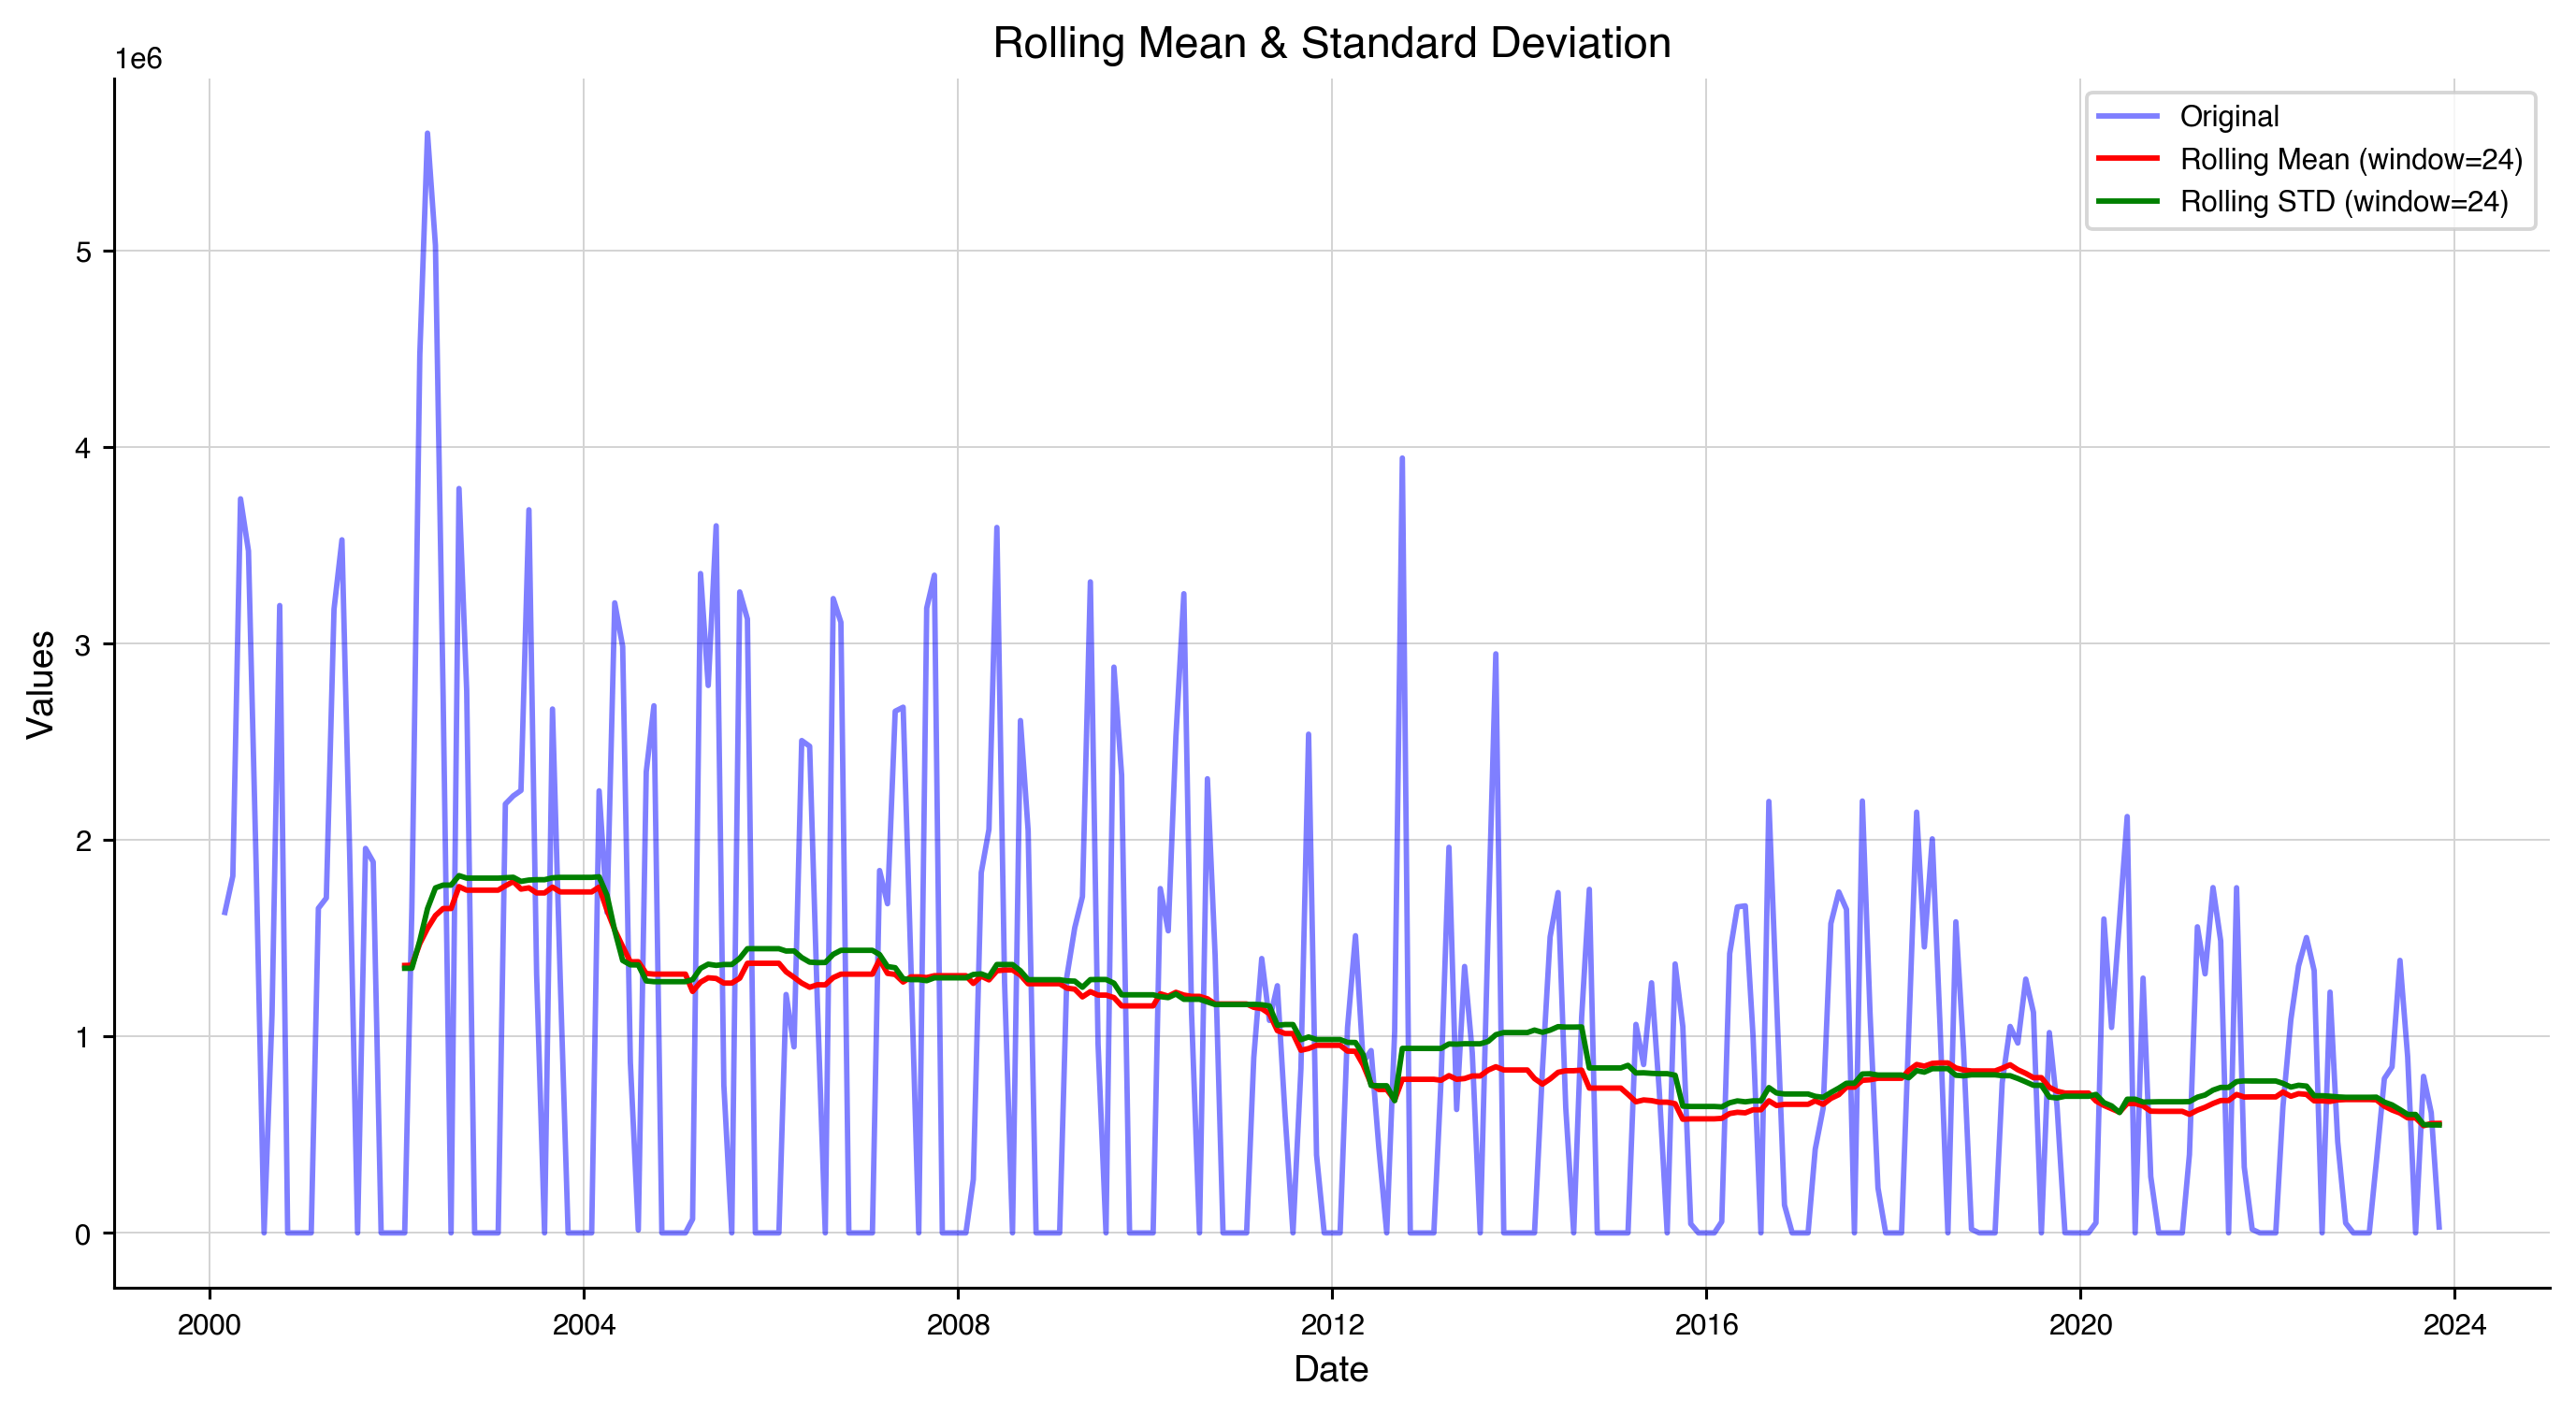

In [76]:
# Plot the rolling mean and standard deviation for a 24-month window 
plot_rolling_mean_and_std(monthly_data['all_motor_vehicles'], window=24)

In [77]:
from statsmodels.graphics.tsaplots import month_plot

In [78]:
monthly_data["all_motor_vehicles"].head()

timestamp
2000-03-01    1630674.0
2000-04-01    1816143.0
2000-05-01    3735104.0
2000-06-01    3469829.0
2000-07-01    1868494.0
Freq: MS, Name: all_motor_vehicles, dtype: float64

In [79]:
monthly_data.head()

all_motor_vehicles
timestamp                     
2000-03-01           1630674.0
2000-04-01           1816143.0
2000-05-01           3735104.0
2000-06-01           3469829.0
2000-07-01           1868494.0

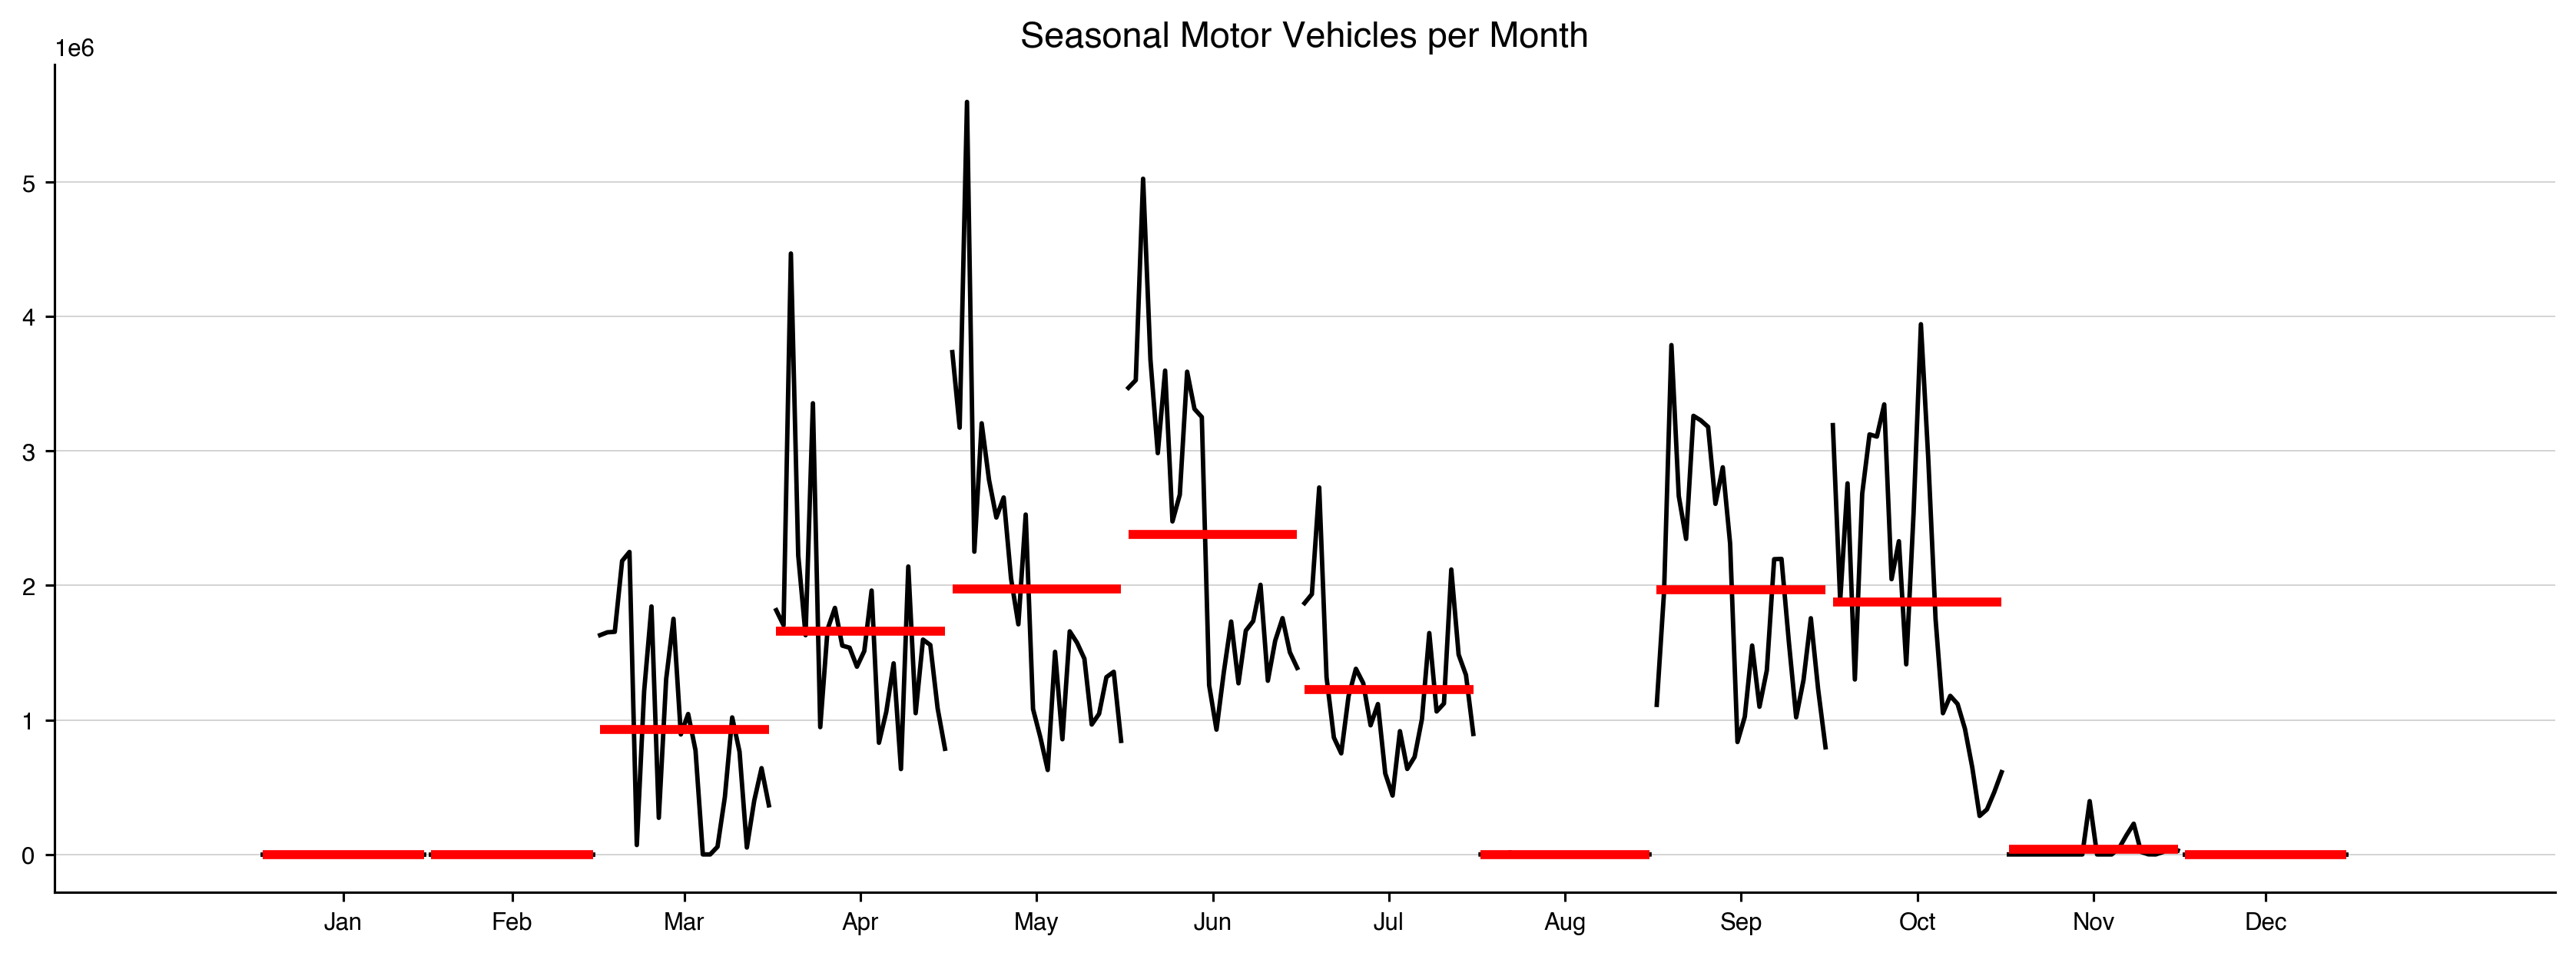

In [80]:
plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_data["all_motor_vehicles"], ax=plt.gca())
plt.title("Seasonal Motor Vehicles per Month")
sns.despine()
plt.show()

**Key Observation**

- Seasonal Pattern:

The graph clearly indicates seasonality as vehicle activity fluctuates between months.
Activity is at its lowest or close to zero in the winter months of January, February, November, and December.
Vehicle activity increases sharply from March onward and peaks at various points during the spring, summer, and early fall months.

- Higher Activity in Warmer Months:

The highest activity is visible during spring and summer months, particularly from April to October. This could be due to increased travel or events happening during these periods.
June, July, and September seem to exhibit the highest peaks in motor vehicle activity, followed by a dip in August and another increase in October.

- Red Horizontal Lines:

These red lines seem to represent the average or median vehicle activity within each month, giving a sense of central tendency amidst the fluctuating data.
In months like April, May, and October, the red lines show higher averages compared to months like March or August, where activity seems to be lower on average.

- Low Activity Months:

November and December show very little motor vehicle activity, potentially due to colder weather, holidays, or reduced traffic during these months.
Similarly, January and February also show close to zero vehicle activity, reinforcing the idea of low wintertime traffic or seasonality effects.

##### Dealing with Non-Stationarity

**Consideration**

Initial assumptions for before running the tests

- Null Hypothesis (H0): The series indicates that it is non-stationary.
- Alternative Hypothesis (H1): The series is stationary. -- supporting our  Rolling Mean & Standard Deviation analysis results

In [81]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series: pd.Series) -> None:
    """
    Perform the Augmented Dickey-Fuller test to check stationarity.
    
    Args:
        series (pd.Series): Time series data
    
    Returns:
        None
    """
    result = adfuller(series.dropna()) 
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

In [82]:
def perform_kpss_test(df: pd.DataFrame) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data

    Returns: None
    """

    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

In [83]:

# Perform the ADF test 
perform_adf_test(monthly_data['all_motor_vehicles'])
perform_kpss_test(monthly_data)

ADF Statistic: -1.631771
p-value: 0.466564
Critical Values:
   1%: -3.4547128138328875
   5%: -2.8722649771800155
   10%: -2.5724850011573914

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 1.633470
p-value: 0.010000
Number of lags used: 5
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


**Notes**
- ADF statistic (-4.106867) is less than the 1% critical value (-3.454988) and the p-value (0.000944) is much less than 0.05, we reject the null hypothesis. This means that the series is stationary.
- Both ADF and KPSS tests are consistent in suggesting that the time series is stationary. The ADF test rejected non-stationarity, and the KPSS test did not reject stationarity, which reinforces the conclusion that the series is indeed stationary.
- **Both the ADF and KPSS tests suggest the data is stationary, supporting the Rolling Mean & Standard Deviation analysis result.**

In [84]:
diff_data = monthly_data['all_motor_vehicles'].diff().dropna() #  calculates the difference between consecutive data points to stabilize the mean of the series

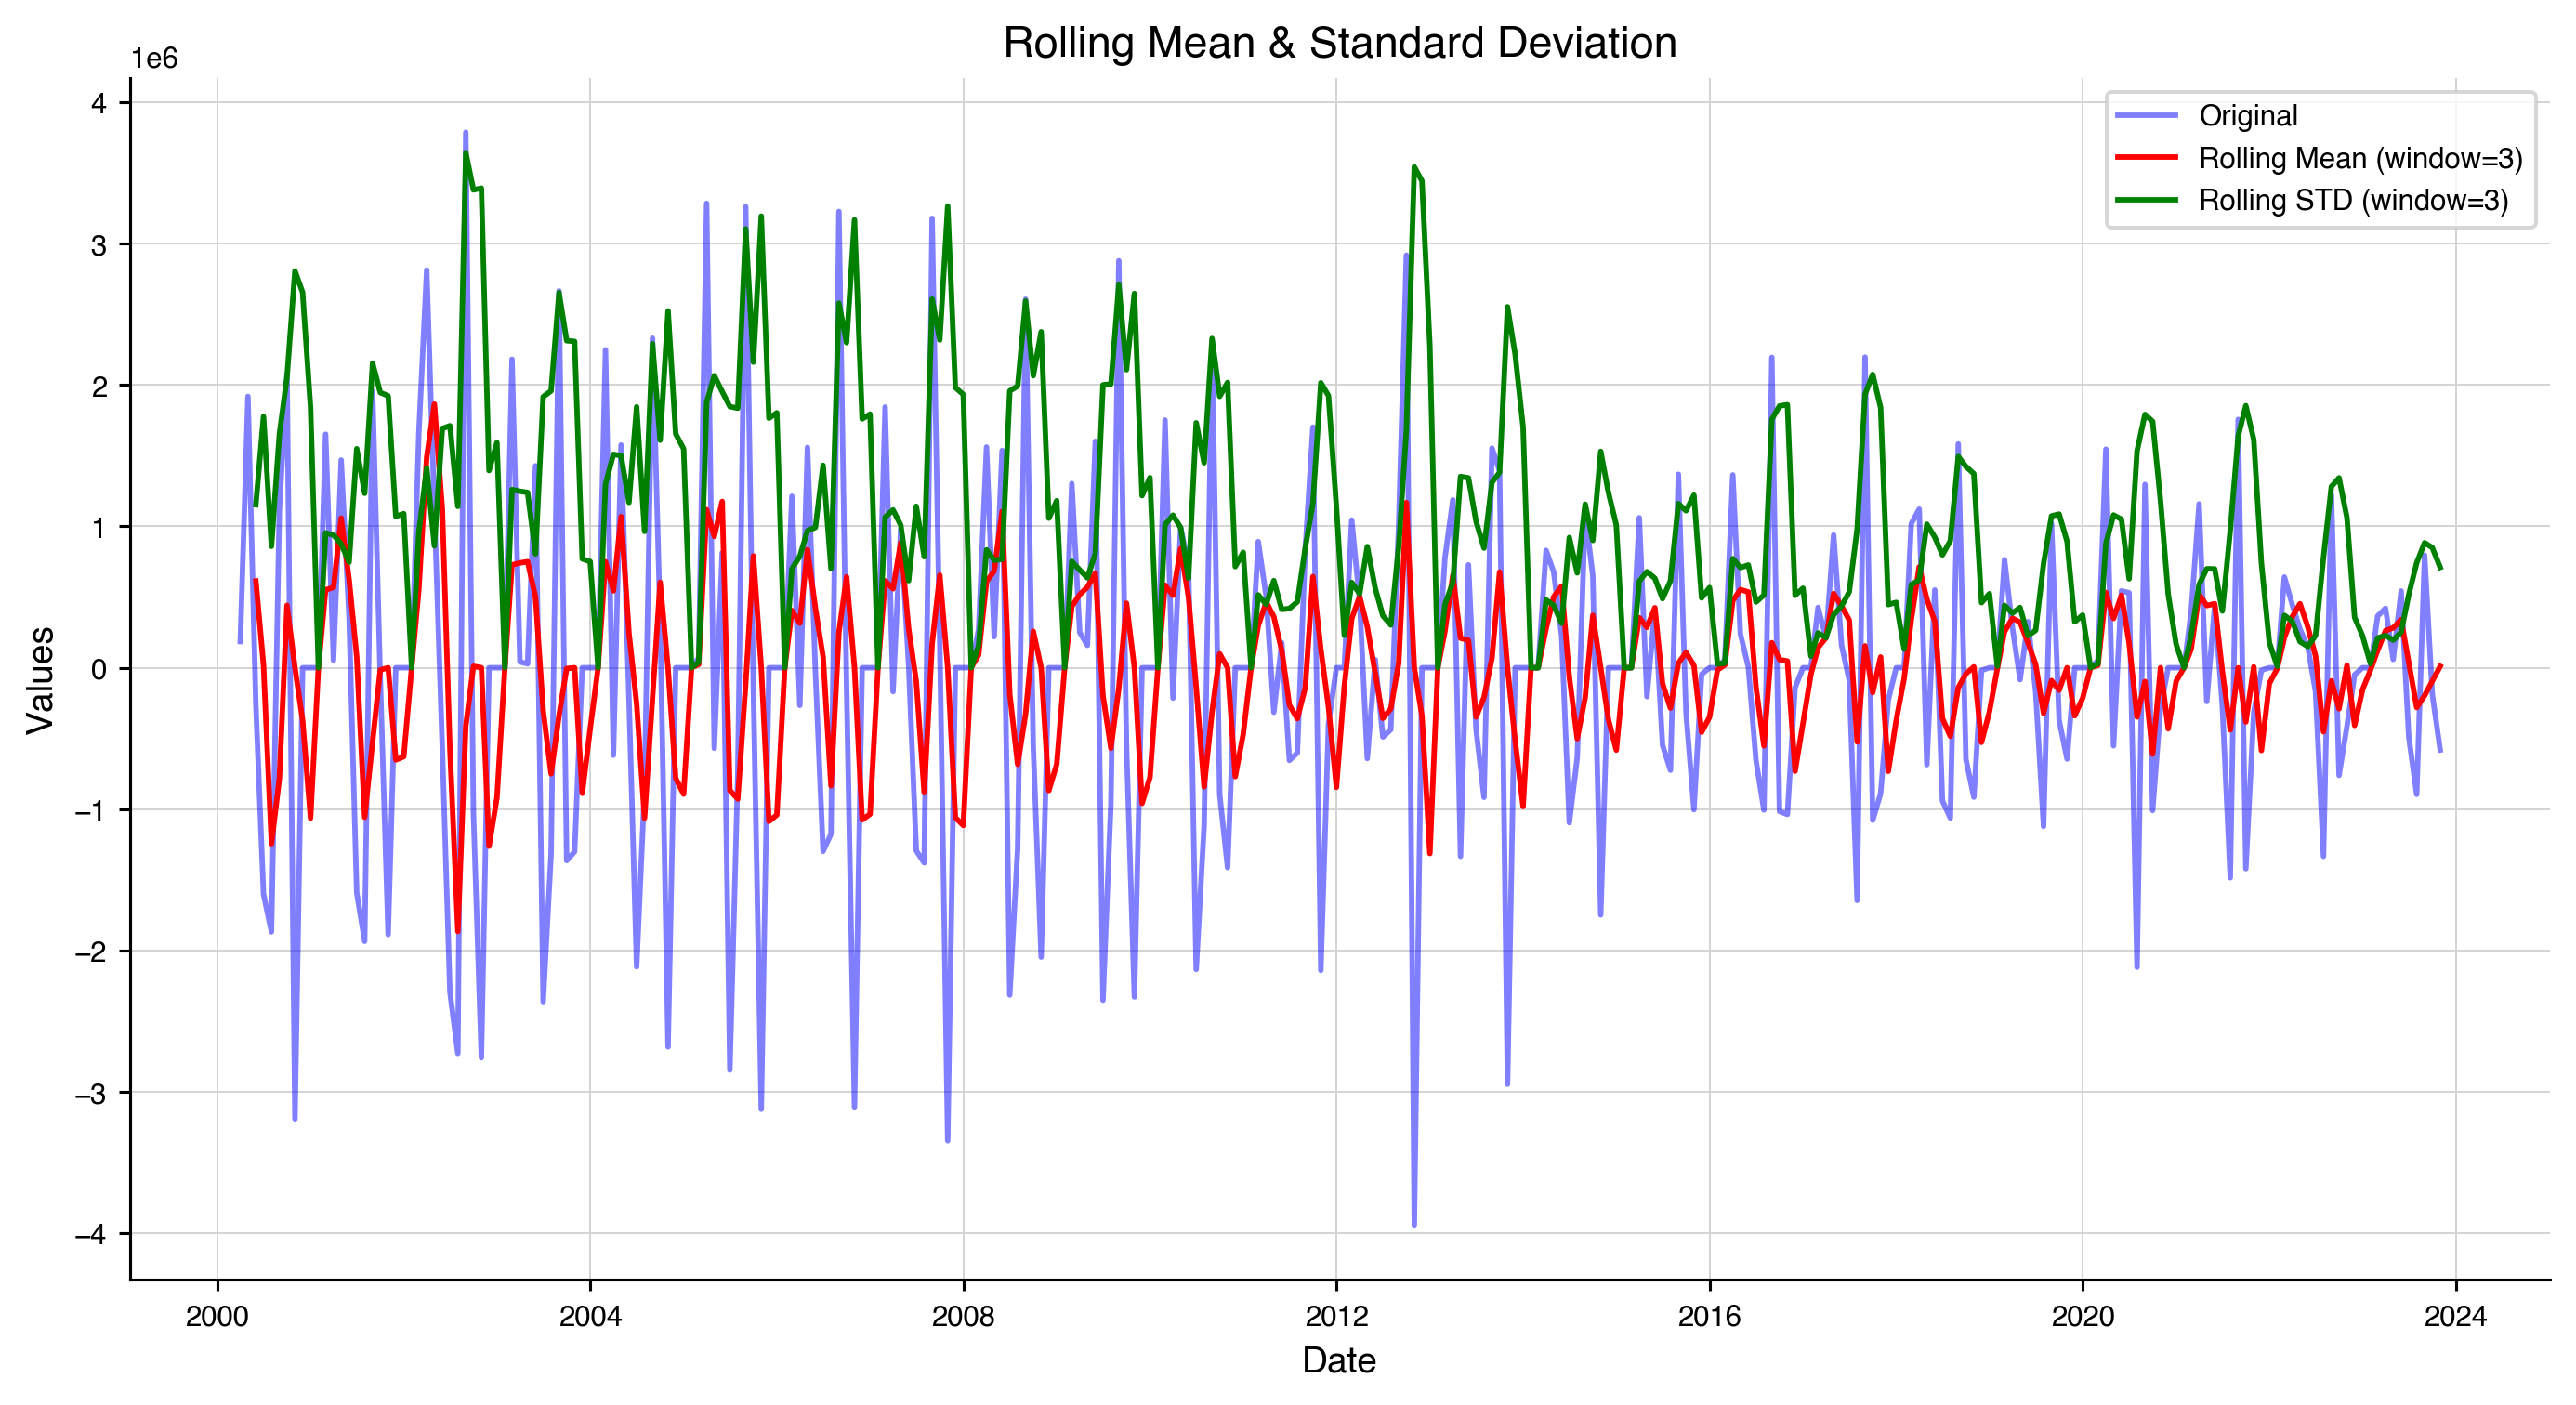

In [85]:
# Plot rolling mean and standard deviation after differencing
plot_rolling_mean_and_std(diff_data, window=3)

In [86]:
# Perform the Augmented Dickey-Fuller test on the differenced data
perform_adf_test(diff_data)
perform_kpss_test(diff_data)

ADF Statistic: -7.914795
p-value: 0.000000
Critical Values:
   1%: -3.4547128138328875
   5%: -2.8722649771800155
   10%: -2.5724850011573914

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.046675
p-value: 0.100000
Number of lags used: 26
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


**Observation**
- Stationarity Achieved:
Both the rolling mean (red) and rolling standard deviation (green) remain relatively stable over time, indicating that differencing has helped stabilize the time series.
The rolling mean is centered around zero, and the rolling standard deviation shows no increasing or decreasing trend, which are both indicators of a stationary time series.

- Remaining Fluctuations:

Although differencing has reduced the overall trends, the series still shows some volatility, as evidenced by the fluctuations in the original (blue) line.


- Test Results after differentiating

    - The ADF statistic (-6.926411) is much smaller (more negative) than all the critical values (1%, 5%, and 10% levels). The p-value (0.000000) is much smaller than 0.05, which means we can reject the null hypothesis that the series has a unit root (non-stationary). Therefore, the ADF test indicates that the time series is stationary after differencing.
    - The KPSS statistic (0.038247) is below all the critical values, and the p-value (0.100000) is greater than 0.05. This means we fail to reject the null hypothesis that the series is stationary. The KPSS test confirms that the series is stationary.


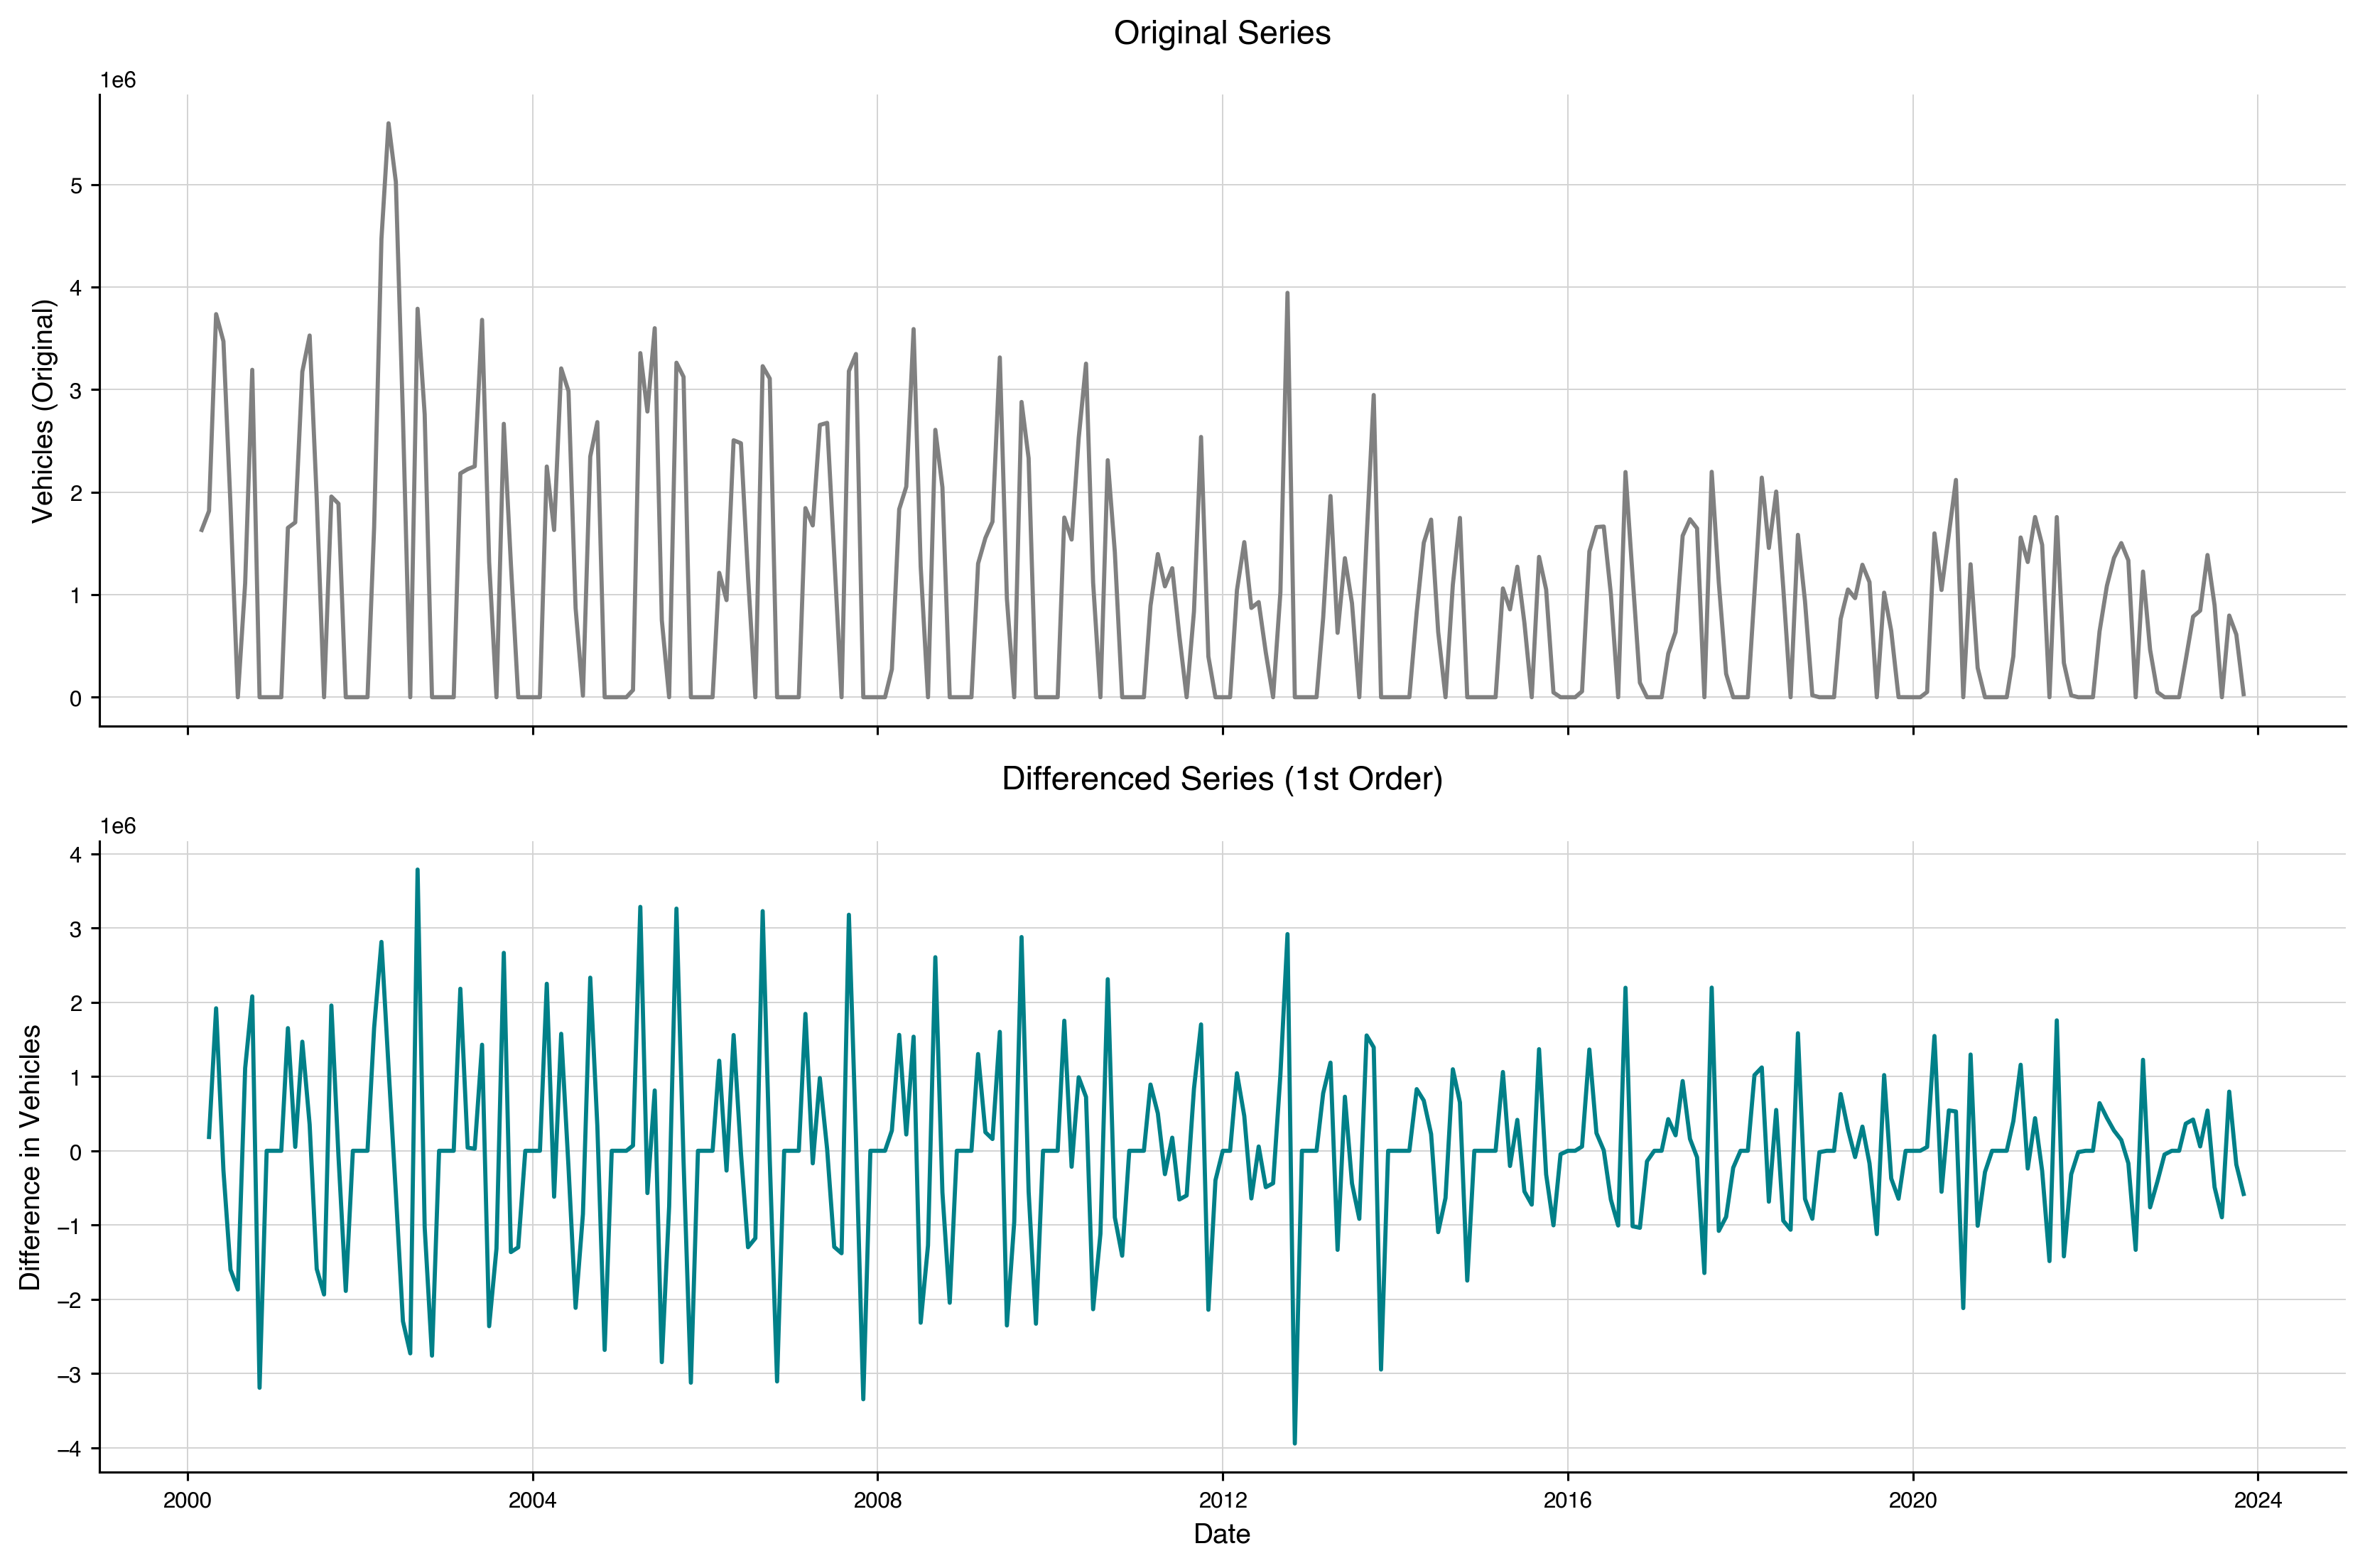

In [87]:
# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# Plot the original data in the first subplot
ax1.plot(monthly_data['all_motor_vehicles'], color='#808080')
ax1.set_ylabel('Vehicles (Original)')
ax1.set_title('Original Series\n')

# Plot the differenced data in the second subplot
ax2.plot(diff_data, color='#008088')
ax2.set_xlabel('Date')
ax2.set_ylabel('Difference in Vehicles')
ax2.set_title('Differenced Series (1st Order)\n')

# Add a grid and show the plot
ax1.grid(True)
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Autorrelation Analysis

**Consideration**

Autocorrelation measures the relationship between a time series's current value and its past values (lags), helping to determine if the present state of the series is influenced by previous observations. This is important for building forecasting models.

In [88]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

def lag_plots(series: pd.Series, lags=[1, 12, 24]) -> None:
    """
    This function plots the lag correlation between 
    current y(t) and y(t-1), y(t-12), and y(t-24) lags (default) 
    or any custom lag provided.
    
    Args:
        series (pd.Series): The time series data (single column).
        lags (list): List of lag values for which to create lag plots.
    
    Returns:
        None
    """
    
    # Number of subplots based on the number of lags
    num_lags = len(lags)
    fig, axes = plt.subplots(1, num_lags, figsize=(16, 9), facecolor='w')
    
    # Loop over the lags to create lag plots for each specified lag
    for i, lag in enumerate(lags):
        lag_plot(series, lag=lag, ax=axes[i], c='#187bcd' if i % 2 == 0 else 'grey')
        axes[i].set_title(f"y(t+{lag})", fontsize=15, pad=10)
        axes[i].grid(linestyle=":", color='grey')
    
    
    plt.tight_layout()
    plt.show()

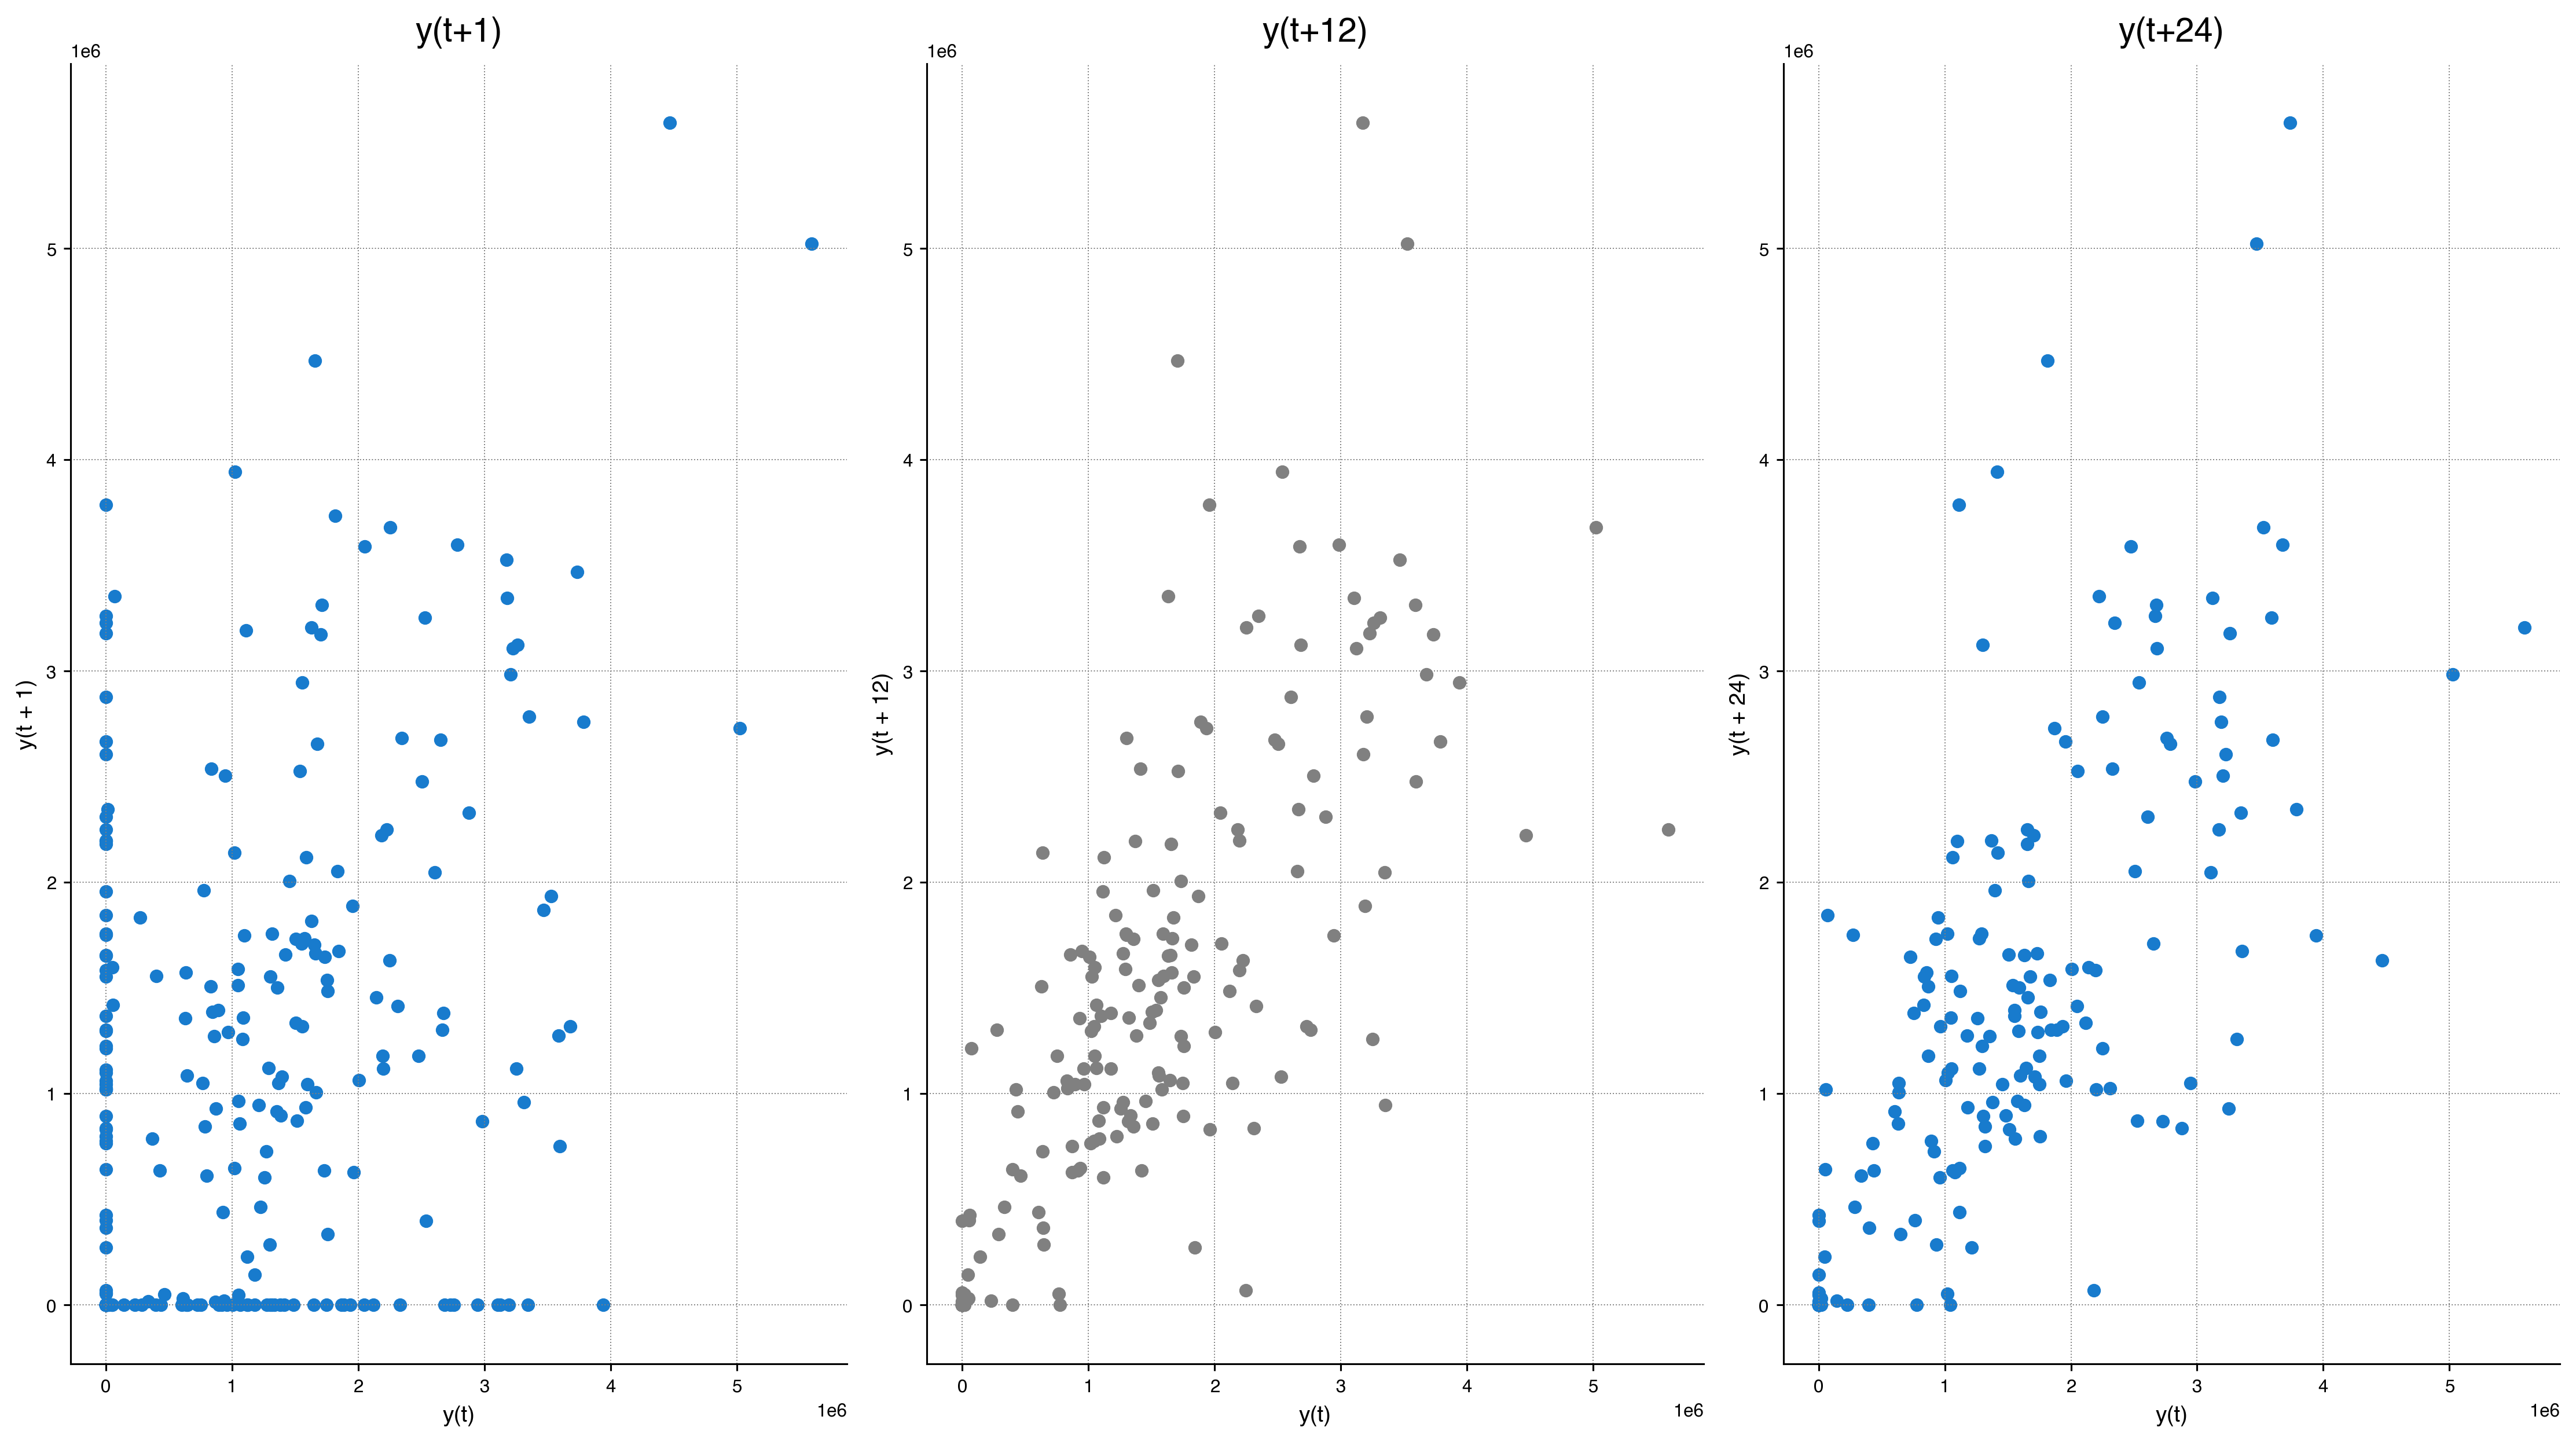

In [89]:
# Plot lag correlations for original series
lag_plots(monthly_data['all_motor_vehicles'], lags=[1, 12, 24])  

**Key Insights:**

**Overall, the Autocorrelation weakens as the lag increases, meaning that earlier values have less influence on future values as the gap increases.**

- Lag 1 (y(t+1)): There is some autocorrelation at lag 1, which implies that the values in the time series are somewhat influenced by their immediately preceding values.
- Lag 12 (y(t+12)): The autocorrelation is weaker, but there might be a hint of a seasonal pattern. This aligns with the monthly cycle data we are attempting to forecast.
- Lag 24 (y(t+24)): The autocorrelation is much weaker at this lag, indicating that values 24 time periods apart are not strongly related.



### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

**Notes**

Using ACF and PACF plots to further determine whether there is seasonality or trend in the data can provide useful insights when using Prophet for time series modelling.

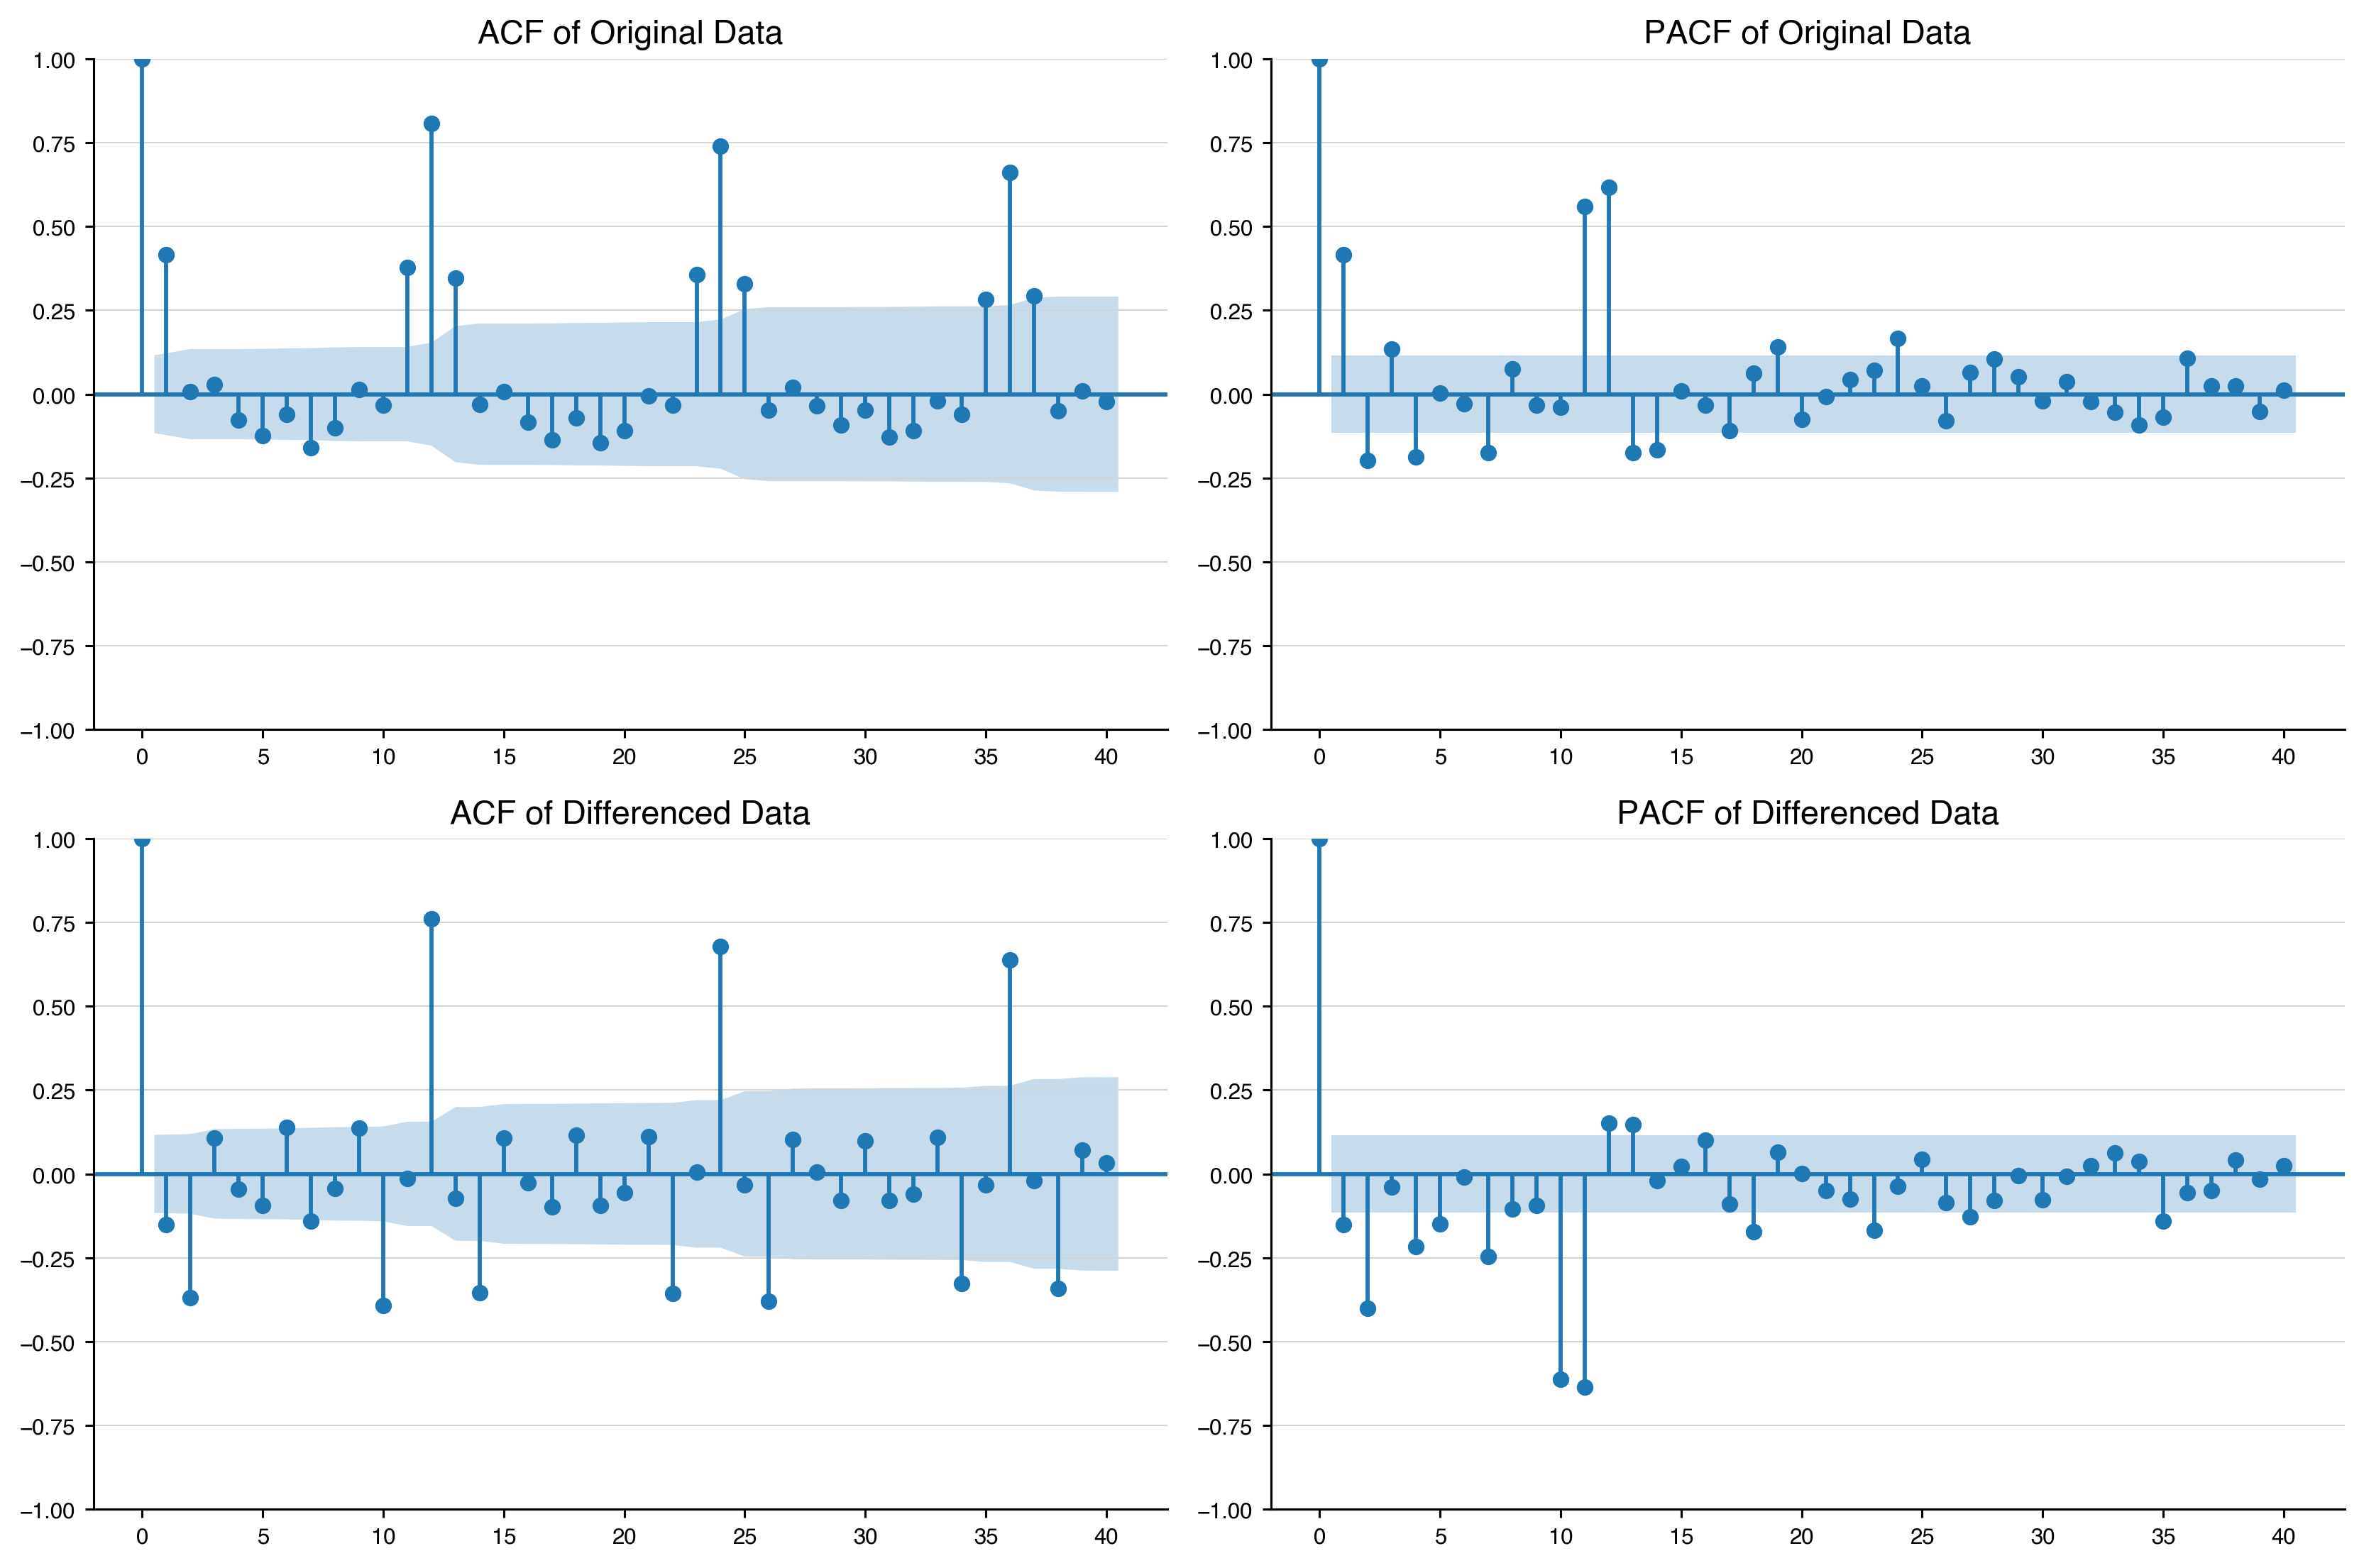

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Apply first-order differencing to the data
diff_data = monthly_data['all_motor_vehicles'].diff().dropna()

# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 8))

# Plot the ACF for the original data
plot_acf(monthly_data['all_motor_vehicles'].dropna(), lags=40, ax=ax1[0])
ax1[0].set_title('ACF of Original Data')

# Plot the PACF for the original data
plot_pacf(monthly_data['all_motor_vehicles'].dropna(), lags=40, ax=ax1[1])
ax1[1].set_title('PACF of Original Data')

# Plot the ACF for the differenced data
plot_acf(diff_data, lags=40, ax=ax2[0])
ax2[0].set_title('ACF of Differenced Data')

# Plot the PACF for the differenced data
plot_pacf(diff_data, lags=40, ax=ax2[1])
ax2[1].set_title('PACF of Differenced Data')

# Display the plots
plt.tight_layout()
plt.show()

**Observation**

- Original Data
  - The PACF shows a strong correlation at the first lag, with significant spikes at lags 10 and 25, indicating autocorrelation in the time series. Significant spikes at lags 10, 20, 25, and 35 suggest dependencies at these lags.
 
- Differentiated Data
    - The ACF plot for the differenced data shows a quick drop in correlation after lag 1, suggesting the removal of the trend and increased stationarity. Only lag 10 and 25 show significant spikes, indicating weaker autocorrelation than the original data.

    - The PACF also displays a significant spike at lag 1, followed by smaller spikes at lag 10 and 25, suggesting residual autoregressive behavior in the differenced series, but with improved stationarity compared to the original data.


## Decomposition

**Understand the different components of the time series and how they influence the overall traffic data**
- Get a clear view of the underlying components of the time series (trend, seasonality, residuals)

In [91]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_series(series: pd.Series, period: int, title: str) -> None:
    """
    This function decomposes the time series into trend, seasonality, and residuals.
    
    Args:
        series (pd.Series): The time series data to decompose.
        period (int): The number of observations per cycle (e.g., 12 for monthly data).
        title (str): Title for the plot.
    
    Returns:
        None
    """
    # Decomposition
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), facecolor='w')

    ax1.plot(series, label='Original', color='blue')
    ax1.set_title('Original Series')
    ax1.legend()

    ax2.plot(trend, label='Trend', color='red')
    ax2.set_title('Trend')
    ax2.legend()

    ax3.plot(seasonal, label='Seasonality', color='green')
    ax3.set_title('Seasonality')
    ax3.legend()

    ax4.plot(residual, label='Residuals', color='orange')
    ax4.set_title('Residuals')
    ax4.legend()

    # Add title and layout adjustments
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [92]:
monthly_data.columns

Index(['all_motor_vehicles'], dtype='object')

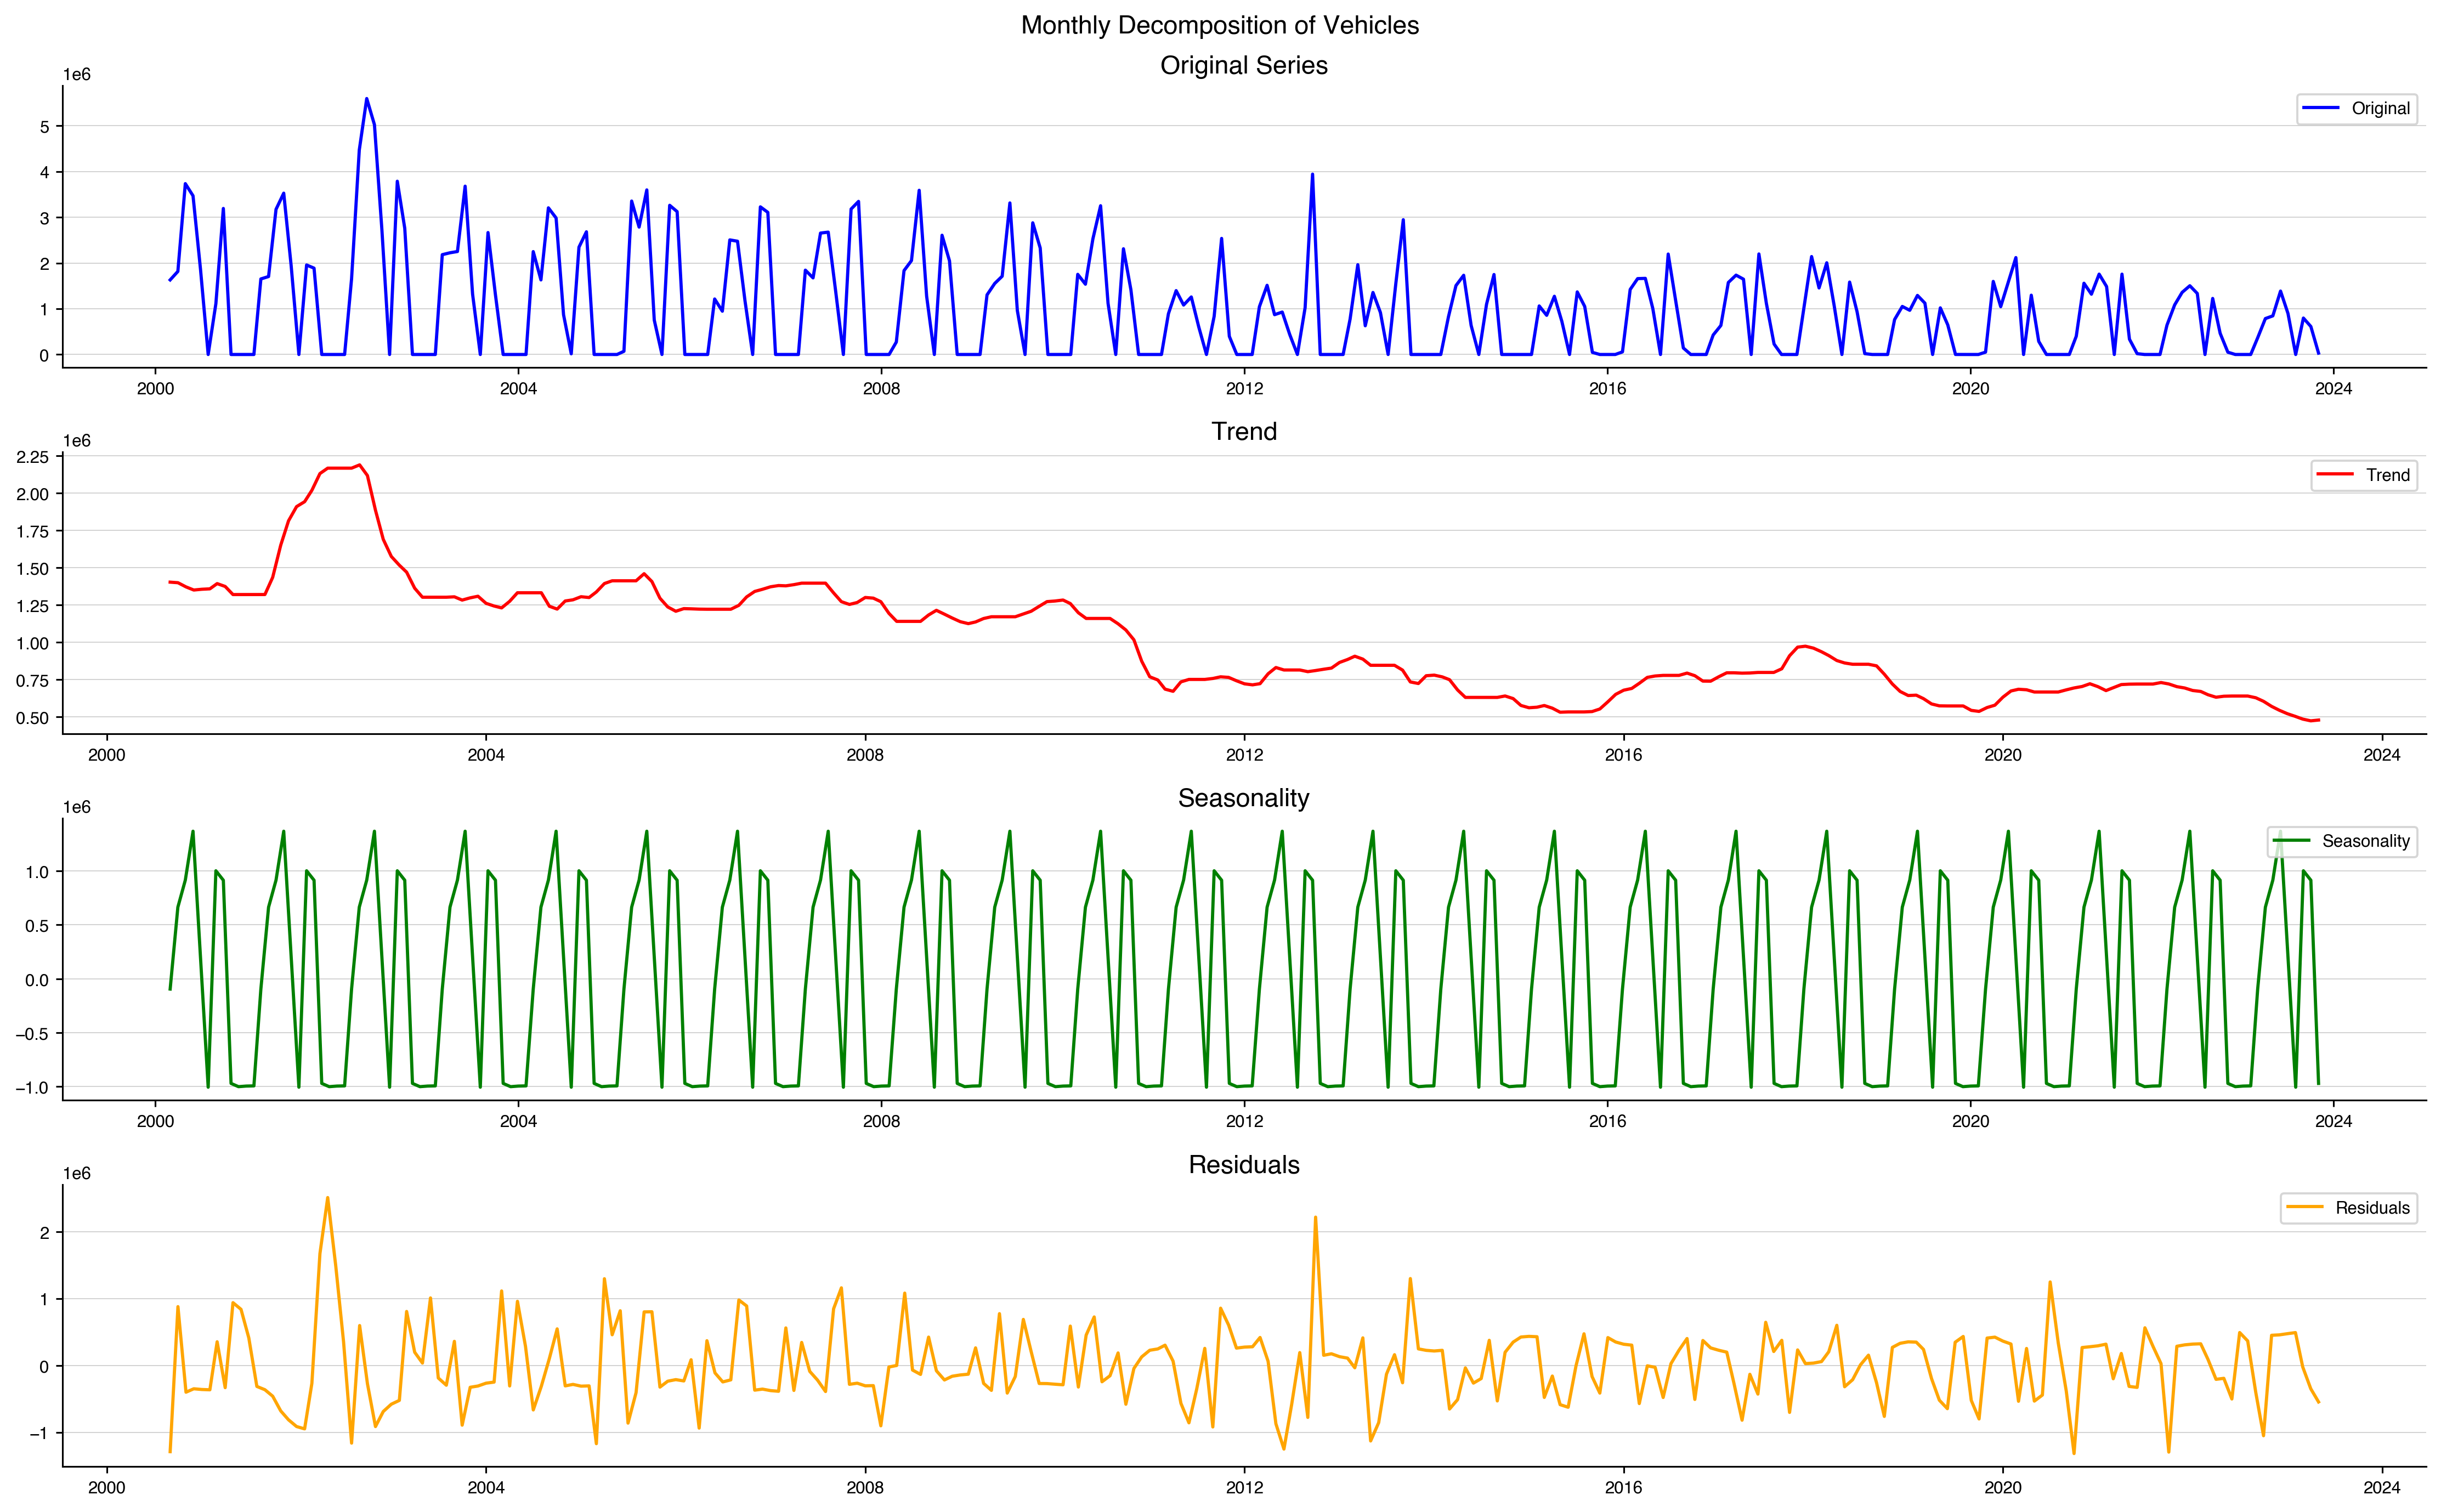

In [93]:
# Decompose the monthly data for 'cars_and_taxis_x'
decompose_series(monthly_data['all_motor_vehicles'], period=12, title='Monthly Decomposition of Vehicles')

**Key Insights**

The graph displays the raw vehicle count data, showing both seasonal and trend-based elements. 

- The trend indicates long-term shifts in vehicle usage, with a decline around 2008–2014 followed by a recovery and another slight decline in recent years.
- The seasonality is strong and consistent, indicating a predictable annual cycle in vehicle counts.
- The residuals are relatively small and centered around zero, suggesting that most of the variation in the data has been explained by the trend and seasonal components.


In [94]:
diff_data.head()

timestamp
2000-04-01     185469.0
2000-05-01    1918961.0
2000-06-01    -265275.0
2000-07-01   -1601335.0
2000-08-01   -1868494.0
Freq: MS, Name: all_motor_vehicles, dtype: float64

In [95]:
monthly_data.head()

all_motor_vehicles
timestamp                     
2000-03-01           1630674.0
2000-04-01           1816143.0
2000-05-01           3735104.0
2000-06-01           3469829.0
2000-07-01           1868494.0

In [96]:
monthly_data.to_csv("../data/monthly_data.csv")